# Исследование объявлений о продаже квартир

### Описание проекта

В распоряжении данные архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости. Задача проекта — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

### План проекта

    1. Ознакомление с данными
    2. Предобработка данных
    3. Исследовательский анализ данных
        3.1. Анализ данных о количестве дней, сколько были размещены объявления о продаже квартиры
        3.2. Определение фактовов, больше всего влияющих на общую (полную) стоимость объекта
        3.3. Определение средней цены одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений
        3.4. Определение средней цены каждого километра до центра города для квартир, расположенных в Санкт-Петербурге
    4. Выводы

### Описание данных

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### 1. Ознакомление с данными
<a id='intro'> </a>

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#чтение файла и сохранение данных
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
#вывод первых 5 строк    
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
#вывод всех атрибутов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

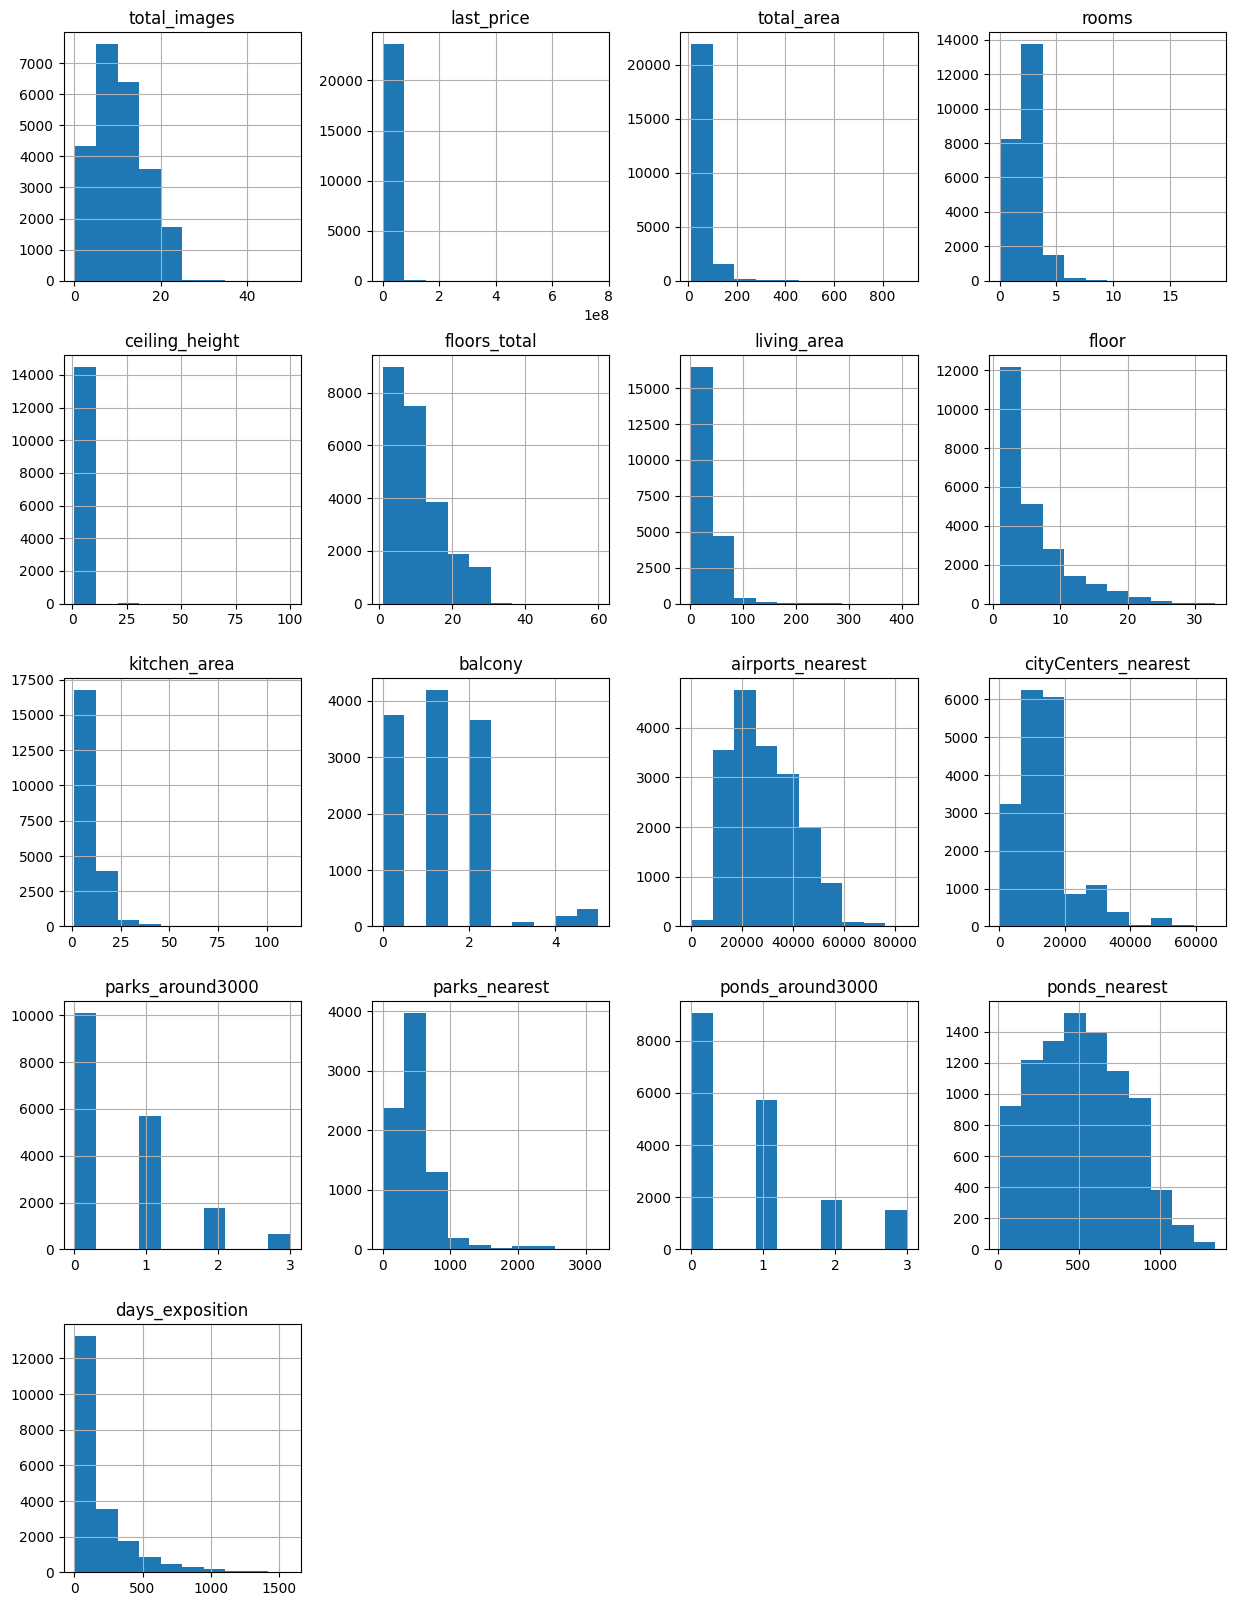

In [4]:
#построение гистограмм для каждого стоблца из data
data.hist(figsize=(15,20));

**Вывод:** ознакомились с предоставленными данными сервиса Яндекс Недвижимости. Всего в предоставленных данных 23699 объекта. Есть пропущенные значения в нескольких стоблцах. Также присутствует некорректный тип данных для некоторых столбцов.

### 2. Предобработка данных
<a id='intro_1'> </a>

Определим количество пропущенных значений в данных:

In [5]:
#количество пропущенных значений
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Определить количество этажей в здании, где продается квартира, или название населенного пункта по остальным даным невозможно. Для корректного дальнейшего анализа данные строки исключаем из датафрейма.

In [6]:
#удаляем строки с пропусками в указании количества этажей в здании и названий населенных пунктов
data = data.dropna(subset=['floors_total', 'locality_name']).reset_index(drop=True)

По стандарту высота потолка может зависеть от месторасположения населенного пункта (климатические широты), также, возможно, высота потолков зависит от этажности дома.
Проанализируем следующие данные:

In [7]:
#сводная таблица по количеству квартир и медиане высоты потолков для каждого населенного пункта
data.pivot_table(index=['locality_name'], values='ceiling_height', aggfunc=['count', 'median'])

,count,median
,ceiling_height,ceiling_height
locality_name,,
Бокситогорск,2,3.90
Волосово,19,2.50
Волхов,58,2.58
Всеволожск,272,2.70
Выборг,98,2.55
...,...,...
село Путилово,2,2.55
село Рождествено,0,NaN


Зависимости медианы высоты потолков от населенного пункта (по широте климатического пояса) не прослеживается

In [8]:
#сводная таблица по этажности дома, в котором расположена квартира
data.pivot_table(index=['floors_total'], values='ceiling_height', aggfunc=['count', 'median'])

,count,median
,ceiling_height,ceiling_height
floors_total,,
1.0,10,2.80
2.0,213,2.70
3.0,399,2.80
4.0,787,3.00
5.0,3662,2.55
6.0,618,3.00
7.0,397,3.00
8.0,219,2.80


Зависимость также не прослеживается. Так что определить высоту потолков в зависимости от других данных невозможно. Однако количество пропущенных значений существенно, поэтому заменим пропущенные значения медианой высоты потолков по всему датафрейму

In [9]:
#замена пропущенных значений высоты потолков на медианное
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

В данных также есть пропущенные значения в столбцах с указанием жилой площади и площади кухни. Однако присутсвует столбец с указанием общей площади жилья. Заменим пропущенные значения указанных площадей на значение произведения общей площади конкретной квартиры на среднее значение по всем данным доли жилой площади или площади кухни от общей площади квартиры. 
Но для начала проверим, не оказалось ли в данных квартир, для которых сумма жилой площади и площади кухни превышает общую площадь:

In [10]:
#определяем количество квартир, попадающих под заданные условия
(data['living_area']+data['kitchen_area']>data['total_area']).value_counts()

False    23501
True        64
dtype: int64

Исключим данные аномалии из исследования:

In [11]:
#исючаем строки, где сумма площади кухни и жилой площад превышает общую площадь
data = data.drop(index = data[(data['living_area']+data['kitchen_area'])>data['total_area']].index).reset_index(drop=True)

Далее заменим пропущенные значения в указании жилой площади на расчитанное как произведение общей площади на среднее значение по всем данным доли жилой площади от общей:

In [12]:
#замена пропущенных значений в указании жилой площади
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area']* \
                                                                                 (data['living_area']/data['total_area']).mean()

Теперь проверим, не создали ли мы таким образом аномалии, от которых избавились. Однако для корректных вычислений необходимо заменить отсутствующие значения площади кухни на 0.

In [13]:
#проверяем, нет ли квартиры с указанной площадью кухни 0 кв м
data[data['kitchen_area']==0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [14]:
#сохраняем значение средней доли площади кухни от общей, так как при изменении отсутствующих значений на 0 среднее изменится
kitchen_area_mean = (data['kitchen_area']/data['total_area']).mean()

In [15]:
#заменяем пропущенные значения площади кухни на 0
data['kitchen_area'] = data['kitchen_area'].fillna(0)

In [16]:
#проверяем, сколько аномальных данных мы сделали
(data['living_area']+data['kitchen_area']>data['total_area']).value_counts()

False    23493
True         8
dtype: int64

Исключаем данные строки:

In [17]:
data = data[data['living_area']+data['kitchen_area']<=data['total_area']]

Далее заменяем пропуски значений площади кухни (которые теперь имеют значение 0) на рассчитанное через среднюю долю:

In [18]:
#замена пропущеных значений в указании площади кухни
data.loc[data['kitchen_area']==0, 'kitchen_area'] = data.loc[data['kitchen_area']==0, 'total_area']*kitchen_area_mean

Проверяем полученные значения на предмет аномалии (по аналогии с жилой площадью):

In [19]:
#проверяем, сколько аномальных данных мы сделали
(data['living_area']+data['kitchen_area']>data['total_area']).value_counts()

False    23442
True        51
dtype: int64

Исключаем данные строки:

In [20]:
data = data[data['living_area']+data['kitchen_area']<=data['total_area']]

Также обнаружены пропуски в стобце с указанием, относится ли данная квартира к апартаментам или нет. Заменим пропущенные значения на False. Ведь скорее всего пользователь, который заполняет объявление о продаже апартаментов, данный пункт не упустит.
Пропуски в указании количества балконов логично заменить на 0.

In [21]:
#замена пропущенных значений в указании апартаментов на значение False
data['is_apartment'] = data['is_apartment'].fillna(False)
#замена пропущенных значений в указании количество балконов на 0
data['balcony'] = data['balcony'].fillna(0)

Заполнить пропущенные значения в указании расстояний до центра города, ближайшего аэропорта/парка/водоема логичным образом не получится.
Скорее всего пропущенные значения в указании числа парков и водоемов в радиусе 3 км связаны с отсутствием данных объектов на заданном расстоянии. Однако сначала перепроверим, не указано ли расстояние до ближайшего парка или водоема.

In [22]:
#определяем количество объявлений, в которых стоят пропуски и  указании количества парков в радиусе 3 км, 
# и в указании расстояния до ближайшего парка
data[data['parks_around3000'].isna()].shape[0] == data[data['parks_around3000'].isna() & data['parks_nearest'].isna()].shape[0]

True

Значит, для всех пропусков в указании количества парков в радиусе 3 км отсутствуют данные и о расстоянии до ближайшего парка.

In [23]:
#заменяем пропущенные значения в указании количества парков в радиусе 3 км на 0
data['parks_around3000'] = data['parks_around3000'].fillna(0)

Для водоемов проведем аналогичный порядок действий:

In [24]:
#определяем количество объявлений, в которых стоят пропуски и  указании количества водоемов в радиусе 3 км, 
# и в указании расстояния до ближайшего водоема
data[data['ponds_around3000'].isna()].shape[0] == data[data['ponds_around3000'].isna() & data['ponds_nearest'].isna()].shape[0]

True

Значит, для всех пропусков в указании количества водоемов в радиусе 3 км отсутствуют данные и о расстоянии до ближайшего водоема.

In [25]:
#заменяем пропущенные значения в указании количества водоемов в радиусе 3 км на 0
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Пропущенные знения еще есть в данных о количестве дней, сколько было размещено объявление (от публикации до снятия). Определим диапазон зчений для данного столбца:

In [26]:
print(data['days_exposition'].min(), data['days_exposition'].max())

1.0 1580.0


Для изменения значений данного столбца на целочисленный тип данных, пропущенные значения заменим на -1 (метка о том, что данные пропущены)

In [27]:
#заменяем пропущенные значения на метку -1
data['days_exposition'] = data['days_exposition'].fillna(-1)

In [28]:
#проверяем, все ли пропуски учли
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5486
cityCenters_nearest      5463
parks_around3000            0
parks_nearest           15448
ponds_around3000            0
ponds_nearest           14451
days_exposition             0
dtype: int64

Далее изменим некорректные типы данных:

In [29]:
#изменяем тип данных с указанием количества этажей на целочисленный
data['floors_total'] = data['floors_total'].astype('int')
#изменяем тип данных с указанием количества балконов на целочисленный
data['balcony'] = data['balcony'].astype('int')
#изменяем тип данных с указанием количества парков в радиусе 3 км на целочисленный
data['parks_around3000'] = data['parks_around3000'].astype('int')
#изменяем тип данных с указанием количества водоемов в радиусе 3 км на целочисленный 
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
#изменяем тип данных с указанием количества дней размещения объявления на целочисленный
data['days_exposition'] = data['days_exposition'].astype('int')
#изменяем тип данных с указанием даты публикации объявления на datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [30]:
#проверим изменения
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23442 entries, 0 to 23500
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23442 non-null  int64         
 1   last_price            23442 non-null  float64       
 2   total_area            23442 non-null  float64       
 3   first_day_exposition  23442 non-null  datetime64[ns]
 4   rooms                 23442 non-null  int64         
 5   ceiling_height        23442 non-null  float64       
 6   floors_total          23442 non-null  int32         
 7   living_area           23442 non-null  float64       
 8   floor                 23442 non-null  int64         
 9   is_apartment          23442 non-null  bool          
 10  studio                23442 non-null  bool          
 11  open_plan             23442 non-null  bool          
 12  kitchen_area          23442 non-null  float64       
 13  balcony         

Далее проверим наличие явных дубликатов в данных:

In [31]:
#количество строк-дубликатов
data.duplicated().sum()

0

Далее необходимо проверить наличие неявных дубликатов в указании названий населенных пунктов:

In [32]:
#выводим отсортированные уникальные значения названий населенных пунктов для поиска неявных дубликатов
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городск

В данных было обнаружено много повторений связанных со словом поселок/посёлок, а также городской поселок/поселок городского типа. Для исключения данного типа неявных дубликатов создадим новый столбец 'locality_name_new', в котором будут содержаться только названия одного типа: поселок и поселок городского типа: 

In [33]:
#функция для изменения названия населенного пункта
def rename_locality_name (locality_name):
    name_list = locality_name.split()
    if 'городской' in name_list:
        name_new = ['поселок', 'городского', 'типа']
        name_new.append(name_list[2])
        if len(name_list)>3:
            name_new.append(name_list[3])
        res = ' '.join(name_new)
    elif 'посёлок' in name_list:
        name_list[name_list.index('посёлок')]='поселок'
        res = ' '.join(name_list)
    else:
        res = locality_name
    return res

In [34]:
#создание столбца с измененными названиями населенных пунктов
data['locality_name_new'] = data['locality_name'].apply(rename_locality_name)

В ходе изучений названий населенных пунктов были выявлены следующие неявные дубликаты (наличие дубликатов связано с тем, что Мурино и Кудрово относительно недавно получили статус города, а понятия поселок/деревня достаточно близкие по своему содержанию):

In [35]:
data['locality_name_new'] = data['locality_name_new'].replace('поселок Мурино', 'Мурино')
data['locality_name_new'] = data['locality_name_new'].replace('деревня Кудрово', 'Кудрово')
data['locality_name_new'] = data['locality_name_new'].replace('поселок Гарболово', 'деревня Гарболово')
data['locality_name_new'] = data['locality_name_new'].replace('деревня Зимитицы', 'поселок Зимитицы')
data['locality_name_new'] = data['locality_name_new'].replace('поселок Калитино', 'деревня Калитино')
data['locality_name_new'] = data['locality_name_new'].replace('поселок Рабитицы', 'деревня Рабитицы')
data['locality_name_new'] = data['locality_name_new'].replace('поселок Рябово', 'поселок городского типа Рябово')

Для выявления аномальных значений просмотрим список уникальных значений, отсортированых по возрастанию и убыванию:

In [36]:
display(sorted(data['last_price'].unique(), reverse=True)) # уникальные значения по убыванию
sorted(data['last_price'].unique()) #уникальные значения по возрастанию

[763000000.0,
 420000000.0,
 401300000.0,
 330000000.0,
 300000000.0,
 289238400.0,
 245000000.0,
 240000000.0,
 230000000.0,
 190870000.0,
 180000000.0,
 160000000.0,
 159984000.0,
 159000000.0,
 155000000.0,
 150000000.0,
 148000000.0,
 140000000.0,
 135000000.0,
 131000000.0,
 130278280.0,
 130000000.0,
 125000000.0,
 124480000.0,
 124350000.0,
 124000000.0,
 122000000.0,
 120000000.0,
 119000000.0,
 118000000.0,
 115490000.0,
 99000000.0,
 98000000.0,
 96000000.0,
 95000000.0,
 91500000.0,
 91075000.0,
 90000000.0,
 88000000.0,
 87000000.0,
 86738800.0,
 85000000.0,
 84382000.0,
 84000000.0,
 83820000.0,
 83000000.0,
 82400000.0,
 82000000.0,
 81960000.0,
 80000000.0,
 79339000.0,
 79000000.0,
 77612080.0,
 77349000.0,
 77000000.0,
 76837000.0,
 75000000.0,
 74000000.0,
 73900000.0,
 73884056.0,
 72375000.0,
 72000000.0,
 71000000.0,
 68500000.0,
 68000000.0,
 67000000.0,
 66571000.0,
 66500000.0,
 65850000.0,
 65138176.0,
 65000000.0,
 64990000.0,
 64900000.0,
 64500000.0,
 639000

[12190.0,
 430000.0,
 440000.0,
 450000.0,
 470000.0,
 480000.0,
 490000.0,
 500000.0,
 520000.0,
 530000.0,
 550000.0,
 560000.0,
 565000.0,
 580000.0,
 585000.0,
 590000.0,
 600000.0,
 620000.0,
 630000.0,
 650000.0,
 660000.0,
 680000.0,
 690000.0,
 700000.0,
 710000.0,
 720000.0,
 730000.0,
 740000.0,
 750000.0,
 760000.0,
 770000.0,
 777000.0,
 780000.0,
 790000.0,
 799000.0,
 800000.0,
 820000.0,
 850000.0,
 860000.0,
 869000.0,
 870000.0,
 880000.0,
 890000.0,
 900000.0,
 910000.0,
 920000.0,
 945750.0,
 950000.0,
 965780.0,
 970000.0,
 980000.0,
 990000.0,
 995000.0,
 999000.0,
 999999.0,
 1000000.0,
 1010000.0,
 1020000.0,
 1030000.0,
 1050000.0,
 1060000.0,
 1070000.0,
 1080000.0,
 1090000.0,
 1099000.0,
 1100000.0,
 1110000.0,
 1130000.0,
 1150000.0,
 1170000.0,
 1180000.0,
 1190000.0,
 1199000.0,
 1200000.0,
 1220000.0,
 1230000.0,
 1240000.0,
 1249000.0,
 1250000.0,
 1260000.0,
 1270000.0,
 1280000.0,
 1290000.0,
 1300000.0,
 1310000.0,
 1315000.0,
 1320000.0,
 1330000.0,


Из всего списка бросается в глаза максимальное и минимальное значение стоимости:

In [37]:
display(data[data['last_price'] == data['last_price'].max()]) #объявление с макимальной стоимостью
data[data['last_price'] == data['last_price'].min()] #объявление с минимальной стоимостью

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
12855,19,763000000.0,400.0,2017-09-30,7,2.65,10,250.0,10,False,...,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33,Санкт-Петербург


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
8726,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8,Санкт-Петербург


Логичной причины таких цен в данных не обнаружено, поэтому для дальнейшего исследования исключим данные объявления из набора данных:

In [38]:
#исключаем объявления с аномальной ценой
data = data[(data['last_price'] != data['last_price'].max())&(data['last_price'] != data['last_price'].min())]

Теперь посмотрим значения общей площади квартир:

In [39]:
display(sorted(data['total_area'].unique(), reverse=True)) #значения общей площади по убыванию
sorted(data['total_area'].unique()) #значения общей площади по возрастанию

[900.0,
 631.2,
 631.0,
 618.0,
 590.0,
 517.0,
 507.0,
 500.0,
 495.0,
 494.1,
 491.0,
 488.0,
 483.9,
 470.3,
 460.8,
 441.98,
 431.0,
 422.2,
 413.5,
 410.0,
 402.0,
 401.0,
 400.0,
 399.0,
 398.0,
 380.0,
 374.6,
 374.0,
 373.1,
 371.0,
 365.0,
 364.7,
 364.0,
 363.1,
 363.0,
 356.0,
 347.5,
 347.0,
 342.0,
 338.6,
 336.0,
 327.2,
 323.0,
 320.0,
 317.0,
 316.3,
 315.0,
 313.0,
 312.0,
 310.0,
 309.7,
 307.8,
 304.0,
 301.9,
 300.0,
 297.5,
 295.0,
 293.6,
 292.2,
 290.6,
 290.0,
 288.0,
 287.5,
 285.7,
 284.0,
 283.3,
 283.0,
 281.1,
 280.3,
 280.0,
 277.6,
 275.0,
 274.65,
 274.0,
 272.6,
 270.0,
 268.0,
 267.7,
 266.2,
 263.8,
 260.0,
 259.6,
 259.2,
 257.0,
 256.0,
 255.0,
 254.0,
 253.7,
 253.0,
 251.0,
 250.3,
 250.2,
 250.0,
 249.9,
 249.7,
 249.0,
 248.7,
 248.0,
 245.8,
 245.4,
 245.0,
 244.0,
 243.0,
 242.4,
 241.0,
 240.0,
 239.0,
 238.26,
 237.8,
 237.0,
 236.4,
 236.0,
 235.0,
 234.0,
 232.0,
 231.6,
 231.2,
 231.0,
 230.1,
 230.0,
 229.0,
 228.0,
 226.0,
 225.0,
 224.

[13.0,
 13.2,
 14.0,
 15.0,
 15.5,
 16.0,
 17.0,
 17.2,
 18.0,
 18.4,
 18.5,
 19.0,
 19.5,
 20.0,
 20.1,
 20.3,
 20.5,
 20.6,
 20.67,
 20.8,
 21.0,
 21.1,
 21.3,
 21.4,
 21.57,
 21.6,
 21.7,
 21.8,
 21.89,
 21.9,
 22.0,
 22.2,
 22.23,
 22.3,
 22.4,
 22.5,
 22.7,
 23.0,
 23.06,
 23.29,
 23.3,
 23.39,
 23.4,
 23.5,
 23.55,
 23.6,
 23.69,
 23.7,
 23.8,
 23.98,
 24.0,
 24.05,
 24.1,
 24.2,
 24.26,
 24.3,
 24.4,
 24.42,
 24.5,
 24.6,
 24.62,
 24.64,
 24.7,
 24.75,
 24.8,
 24.9,
 25.0,
 25.07,
 25.2,
 25.3,
 25.33,
 25.36,
 25.41,
 25.48,
 25.5,
 25.55,
 25.6,
 25.63,
 25.7,
 25.8,
 25.9,
 26.0,
 26.05,
 26.09,
 26.1,
 26.18,
 26.2,
 26.23,
 26.4,
 26.45,
 26.49,
 26.5,
 26.6,
 26.69,
 26.7,
 26.8,
 26.9,
 27.0,
 27.1,
 27.2,
 27.3,
 27.32,
 27.4,
 27.5,
 27.55,
 27.56,
 27.6,
 27.7,
 27.8,
 27.81,
 27.9,
 28.0,
 28.01,
 28.05,
 28.1,
 28.16,
 28.2,
 28.3,
 28.4,
 28.49,
 28.5,
 28.6,
 28.61,
 28.66,
 28.7,
 28.71,
 28.8,
 28.86,
 28.9,
 29.0,
 29.1,
 29.14,
 29.2,
 29.24,
 29.3,
 29.4,
 29.

Посмторим повнимательнее на объявления с минимальной и максимальной общей площадью:

In [40]:
display(data[data['total_area'] == data['total_area'].max()])
data[data['total_area'] == data['total_area'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
19378,8,420000000.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,...,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106,Санкт-Петербург


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
17809,3,1400000.0,13.0,2017-12-03,1,2.60,9,7.333762,1,False,...,0,Санкт-Петербург,14350.0,15945.0,0,NaN,1,185.0,410,Санкт-Петербург
19384,3,1850000.0,13.0,2019-03-11,1,3.40,5,7.333762,2,False,...,0,Санкт-Петербург,24915.0,5483.0,1,644.0,0,NaN,24,Санкт-Петербург
19645,0,3800000.0,13.0,2018-07-04,1,2.65,5,10.000000,3,False,...,0,Санкт-Петербург,21302.0,1242.0,1,592.0,3,27.0,9,Санкт-Петербург


Однокомнатная квартира площадью 13 кв м в  Санкт-Петербурге вполне правдоподобное объявление. А вот 12-комнатная квартира площадью 900 кв м не кажется реальной, так что исключим данное объявление из данных

In [41]:
#исключаем объявление о продаже квартиры с площадью 900 кв м
data = data[data['total_area']!= data['total_area'].max()]

Рассмотрим данные о количестве комнат:

In [42]:
sorted(data['rooms'].unique()) #уникальные значения количества комнат по возрастанию

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 19]

In [43]:
data['rooms'].value_counts() #значения и частота встречаемости

1     7954
2     7865
3     5762
4     1169
5      323
0      176
6      103
7       58
8       11
9        8
10       3
11       2
14       2
16       1
19       1
15       1
Name: rooms, dtype: int64

Посмотрим внимательнее на объявления с количеством комнат, превышающем 9:

In [44]:
display(data[data['rooms'] >= 9])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
641,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.80000,7,False,...,0,Санкт-Петербург,23606.0,3148.0,0,NaN,0,NaN,-1,Санкт-Петербург
857,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.00000,4,False,...,0,Санкт-Петербург,38076.0,7950.0,0,NaN,2,435.0,418,Санкт-Петербург
4116,6,23000000.0,272.6,2018-01-11,10,3.14,7,145.90000,7,False,...,1,Санкт-Петербург,10726.0,12169.0,1,191.0,1,531.0,-1,Санкт-Петербург
5314,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.00000,3,False,...,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14,Санкт-Петербург
8755,14,49968900.0,398.0,2017-07-12,9,3.00,2,160.10000,1,False,...,0,Санкт-Петербург,17720.0,16722.0,3,471.0,2,440.0,471,Санкт-Петербург
8793,12,17000000.0,235.0,2018-07-14,9,3.00,6,132.57185,3,False,...,0,Санкт-Петербург,24466.0,5034.0,1,346.0,0,NaN,90,Санкт-Петербург
9478,10,23500000.0,313.0,2017-02-13,9,3.20,6,179.20000,5,False,...,0,Санкт-Петербург,38435.0,10138.0,1,146.0,0,NaN,-1,Санкт-Петербург
9616,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.00000,2,False,...,0,Санкт-Петербург,21469.0,1015.0,1,686.0,2,66.0,813,Санкт-Петербург
12903,0,22250000.0,249.9,2019-04-23,9,3.20,5,157.00000,5,False,...,0,Санкт-Петербург,10328.0,9987.0,2,352.0,0,NaN,-1,Санкт-Петербург
13280,14,19500000.0,309.7,2016-02-03,9,2.65,5,199.00000,5,False,...,0,Санкт-Петербург,10328.0,9987.0,2,352.0,0,NaN,468,Санкт-Петербург


Все квартиры расположены в Санкт-Петербурге, с достаточно большой общей площадью для такого количества комнат. Однако данные можно отнести к редким.

In [45]:
#исключаем редкие значения
data = data[data['rooms'] < 9]

Что касается квартир с 0 комнат: проверим, не являются ли они студиями или квартирами со свободной планировкой:

In [46]:
#квартиры с 0 комнатами
display(data[data['rooms'] == data['rooms'].min()])
#квартиры-студии или квартиры со свободной планировкой с 0 комнатами
data[(data['rooms'] == data['rooms'].min()) & ((data['studio'] == True) | (data['open_plan'] == True))]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
144,1,2450000.0,27.0,2017-03-30,0,2.65,24,15.500000,2,False,...,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,181,Мурино
346,4,2320000.0,25.0,2017-09-27,0,2.65,14,17.000000,1,False,...,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45,Кудрово
504,0,3375000.0,34.4,2017-03-28,0,2.65,26,24.300000,19,False,...,1,посёлок Парголово,53115.0,19292.0,0,NaN,1,593.0,430,поселок Парголово
601,2,1850000.0,25.0,2019-02-20,0,2.65,10,14.103388,7,False,...,0,посёлок Шушары,NaN,NaN,0,NaN,0,NaN,29,поселок Шушары
688,12,2500000.0,24.1,2017-12-01,0,2.75,25,17.500000,21,False,...,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,201,Кудрово
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23015,7,3200000.0,26.0,2017-09-01,0,2.65,25,18.000000,16,False,...,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14,Санкт-Петербург
23246,0,2500000.0,27.7,2017-09-28,0,2.65,24,18.000000,4,False,...,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,4,Мурино
23358,15,3350000.0,26.0,2018-09-07,0,2.65,19,14.667524,8,False,...,0,Санкт-Петербург,18090.0,17092.0,0,NaN,2,112.0,31,Санкт-Петербург
23395,10,1450000.0,29.0,2017-11-11,0,2.65,9,18.000000,8,False,...,2,Никольское,NaN,NaN,0,NaN,0,NaN,82,Никольское


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
144,1,2450000.0,27.0,2017-03-30,0,2.65,24,15.500000,2,False,...,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,181,Мурино
346,4,2320000.0,25.0,2017-09-27,0,2.65,14,17.000000,1,False,...,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45,Кудрово
504,0,3375000.0,34.4,2017-03-28,0,2.65,26,24.300000,19,False,...,1,посёлок Парголово,53115.0,19292.0,0,NaN,1,593.0,430,поселок Парголово
601,2,1850000.0,25.0,2019-02-20,0,2.65,10,14.103388,7,False,...,0,посёлок Шушары,NaN,NaN,0,NaN,0,NaN,29,поселок Шушары
688,12,2500000.0,24.1,2017-12-01,0,2.75,25,17.500000,21,False,...,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,201,Кудрово
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23015,7,3200000.0,26.0,2017-09-01,0,2.65,25,18.000000,16,False,...,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14,Санкт-Петербург
23246,0,2500000.0,27.7,2017-09-28,0,2.65,24,18.000000,4,False,...,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,4,Мурино
23358,15,3350000.0,26.0,2018-09-07,0,2.65,19,14.667524,8,False,...,0,Санкт-Петербург,18090.0,17092.0,0,NaN,2,112.0,31,Санкт-Петербург
23395,10,1450000.0,29.0,2017-11-11,0,2.65,9,18.000000,8,False,...,2,Никольское,NaN,NaN,0,NaN,0,NaN,82,Никольское


Списки совпадают, значит 0 комнат это не аномальное значение, а обозначение квартир-студий или квартир со свободной планировкой.
Далее рассмотрим значения высоты потолков:

In [47]:
sorted(data['ceiling_height'].unique(), reverse=True) #значения высоты потолков по убыванию

[100.0,
 32.0,
 27.0,
 26.0,
 25.0,
 24.0,
 22.6,
 20.0,
 14.0,
 10.3,
 8.3,
 8.0,
 6.0,
 5.6,
 5.5,
 5.3,
 5.2,
 5.0,
 4.9,
 4.8,
 4.7,
 4.65,
 4.5,
 4.45,
 4.4,
 4.37,
 4.3,
 4.25,
 4.2,
 4.19,
 4.15,
 4.14,
 4.1,
 4.06,
 4.0,
 3.98,
 3.95,
 3.93,
 3.9,
 3.88,
 3.87,
 3.86,
 3.85,
 3.84,
 3.83,
 3.82,
 3.8,
 3.78,
 3.76,
 3.75,
 3.7,
 3.69,
 3.68,
 3.67,
 3.66,
 3.65,
 3.63,
 3.62,
 3.6,
 3.59,
 3.58,
 3.57,
 3.56,
 3.55,
 3.54,
 3.53,
 3.52,
 3.51,
 3.5,
 3.49,
 3.48,
 3.47,
 3.46,
 3.45,
 3.44,
 3.42,
 3.4,
 3.39,
 3.38,
 3.37,
 3.36,
 3.35,
 3.34,
 3.33,
 3.32,
 3.31,
 3.3,
 3.29,
 3.28,
 3.27,
 3.26,
 3.25,
 3.24,
 3.23,
 3.22,
 3.21,
 3.2,
 3.18,
 3.17,
 3.16,
 3.15,
 3.14,
 3.13,
 3.12,
 3.11,
 3.1,
 3.09,
 3.08,
 3.07,
 3.06,
 3.05,
 3.04,
 3.03,
 3.02,
 3.01,
 3.0,
 2.99,
 2.98,
 2.97,
 2.96,
 2.95,
 2.94,
 2.93,
 2.92,
 2.91,
 2.9,
 2.89,
 2.88,
 2.87,
 2.86,
 2.85,
 2.84,
 2.83,
 2.82,
 2.81,
 2.8,
 2.79,
 2.78,
 2.77,
 2.76,
 2.75,
 2.74,
 2.73,
 2.72,
 2.71,
 2.7,
 2.69,


По стандартам высота потолков не должна быть ниже 2,5 метров. Однако, стоит учесть, что может быть постройка до введения стандартов, отделка потолка (гипсокартон или натяжной, они тоже уменьшают фактическую высоту). Также стоит обратить внимание на значения, превышающие 6 метров (до 6 метров возможна высота потолков в исторических домах или в элитных новостройках)

In [48]:
display(data[data['ceiling_height'] > 6]) #объявления с высотой потолка выше 6 метров
data[data['ceiling_height'] <= 2] # объявления с высотой потолка, не превышающей 2 метров

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
352,17,3600000.0,55.2,2018-07-12,2,25.0,5,32.0,2,False,...,2,Гатчина,NaN,NaN,0,NaN,0,NaN,259,Гатчина
3122,14,2900000.0,75.0,2018-11-12,3,32.0,3,53.0,2,False,...,0,Волхов,NaN,NaN,0,NaN,0,NaN,-1,Волхов
3446,3,1400000.0,30.0,2018-03-16,1,8.0,5,15.3,2,False,...,0,деревня Нурма,NaN,NaN,0,NaN,0,NaN,125,деревня Нурма
4606,0,4300000.0,45.0,2018-02-01,2,25.0,9,30.0,2,False,...,1,Санкт-Петербург,12016.0,13256.0,1,658.0,1,331.0,181,Санкт-Петербург
4837,7,3000000.0,25.0,2017-09-27,0,27.0,25,17.0,17,False,...,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,28,Мурино
5036,0,3850000.0,30.5,2018-10-03,1,24.0,5,19.5,1,True,...,0,Санкт-Петербург,29686.0,8389.0,3,397.0,1,578.0,7,Санкт-Петербург
5203,0,2500000.0,54.0,2017-10-13,2,27.0,5,30.0,3,False,...,2,деревня Мины,NaN,NaN,0,NaN,0,NaN,540,деревня Мины
5625,4,4400000.0,50.0,2017-08-08,2,26.0,9,21.3,3,False,...,2,Санкт-Петербург,28981.0,10912.0,1,305.0,0,NaN,267,Санкт-Петербург
5761,17,8150000.0,80.0,2019-01-09,2,27.0,36,41.0,13,False,...,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38,Санкт-Петербург
5817,20,5650000.0,45.0,2018-08-15,1,8.3,16,19.3,14,False,...,1,Санкт-Петербург,13069.0,10763.0,0,NaN,1,613.0,14,Санкт-Петербург


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
546,11,2999000.0,33.50,2017-03-30,1,2.00,15,17.500000,6,False,...,0,Санкт-Петербург,33972.0,11746.0,1,520.0,1,949.0,270,Санкт-Петербург
2552,4,2400000.0,62.00,2018-12-27,3,2.00,5,40.000000,4,False,...,1,Луга,NaN,NaN,0,NaN,0,NaN,-1,Луга
4177,1,2120000.0,35.43,2017-12-18,1,2.00,18,16.600000,9,False,...,2,Тосно,NaN,NaN,0,NaN,0,NaN,36,Тосно
5667,5,1500000.0,42.80,2017-08-14,2,1.20,2,27.500000,1,False,...,0,городской посёлок Мга,NaN,NaN,0,NaN,0,NaN,248,поселок городского типа Мга
5804,9,1650000.0,35.50,2018-05-29,1,2.00,5,20.026811,5,False,...,0,Луга,NaN,NaN,0,NaN,0,NaN,100,Луга
11251,4,3300000.0,36.00,2017-06-18,1,2.00,17,15.200000,12,False,...,0,посёлок Металлострой,25268.0,26980.0,0,NaN,0,NaN,53,поселок Металлострой
16312,6,12300000.0,88.30,2019-03-12,3,2.00,5,63.900000,2,False,...,0,Санкт-Петербург,38415.0,7675.0,1,568.0,1,154.0,-1,Санкт-Петербург
16741,0,1500000.0,33.00,2018-10-03,1,2.00,5,20.000000,5,False,...,0,Выборг,NaN,NaN,0,NaN,0,NaN,6,Выборг
16790,5,4100000.0,40.00,2017-10-17,1,1.75,37,17.400000,5,False,...,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,71,Санкт-Петербург
18941,7,2700000.0,56.00,2018-02-04,3,2.00,5,46.000000,1,False,...,0,Выборг,NaN,NaN,0,NaN,0,NaN,282,Выборг


Некоторые значения, превышающие 10, явно указаны не в метрах. Изменим данные значения:

In [49]:
# функция, изменяющая высоту потолков 
def ceiling_height_new (ceiling):
    if ceiling > 10:
        return ceiling/10
    else:
        return ceiling

#применяем функцию к значениям столбца
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_height_new)

Проверим, остались ли значения, превышающие 6 метров:

In [50]:
data[(data['ceiling_height'] > 6)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
3446,3,1400000.0,30.0,2018-03-16,1,8.0,5,15.3,2,False,...,0,деревня Нурма,NaN,NaN,0,NaN,0,NaN,125,деревня Нурма
5817,20,5650000.0,45.0,2018-08-15,1,8.3,16,19.3,14,False,...,1,Санкт-Петербург,13069.0,10763.0,0,NaN,1,613.0,14,Санкт-Петербург
15612,14,5600000.0,67.0,2016-11-11,3,8.0,16,41.0,1,False,...,0,Санкт-Петербург,32691.0,11035.0,1,723.0,0,NaN,474,Санкт-Петербург
17296,0,5350000.0,54.0,2015-06-16,2,8.0,5,29.0,2,False,...,1,Красное Село,24638.0,28062.0,0,NaN,0,NaN,469,Красное Село
22676,0,15000000.0,25.0,2018-07-25,1,10.0,5,14.0,5,True,...,5,Санкт-Петербург,34963.0,8283.0,1,223.0,3,30.0,19,Санкт-Петербург


Исключим объявления о продаже квартир с высотой потолков, превышающей 8 метров и не превышающей 2 метров:

In [51]:
#исключаем аномальные значения высоты полоков
data = data[(data['ceiling_height']>2) & (data['ceiling_height']<8)]

Рассмотрим значения этажности зданий, в которых продаются квартиры:

In [52]:
data['floors_total'].value_counts() #значения и частота встречаемости

5     5739
9     3749
16    1359
12    1354
4     1184
10    1170
25    1062
6      898
17     826
3      660
7      584
14     550
18     496
24     457
8      387
2      375
15     363
23     348
19     336
22     282
20     271
13     227
11     201
27     163
21     157
26     124
1       25
35      23
28      21
36       3
34       1
60       1
52       1
29       1
33       1
Name: floors_total, dtype: int64

In [53]:
#исключаем из данных объявления с редкими и аномальными значениями этажности зданий
data = data[(data['floors_total']!=36) & (data['floors_total']!=34) & (data['floors_total']!=60)&\
            (data['floors_total']!=52)&(data['floors_total']!=29)&(data['floors_total']!=33)]

Далее рассмотрим значения жилой площади:

In [54]:
display(sorted(data['living_area'].unique(), reverse=True)) #значения жилой площади по убыванию
sorted(data['living_area'].unique()) #значения жилой площади по возрастанию

[355.96952009180654,
 347.5,
 332.0,
 322.3,
 312.5,
 301.5,
 300.0,
 282.0677655244109,
 279.6,
 278.73936589122286,
 274.0,
 260.0,
 258.0,
 255.7,
 250.0,
 249.33662201295826,
 248.7,
 248.5,
 239.4,
 238.17802120881254,
 230.0,
 225.6542124195287,
 225.09007688847987,
 220.0,
 218.0,
 216.0,
 211.0,
 209.29428201911287,
 205.90946883281993,
 205.74022817350527,
 204.8376113238272,
 204.0,
 200.0,
 198.0,
 195.0,
 194.0,
 193.5,
 193.0,
 190.0,
 188.7,
 187.9,
 187.0,
 184.9,
 184.0,
 183.7,
 183.0,
 182.8,
 182.0,
 181.8,
 180.0,
 179.0,
 177.3,
 177.0,
 176.6,
 176.2,
 175.0,
 174.3,
 174.0,
 171.4972014388418,
 171.0,
 170.8,
 170.0,
 167.0,
 166.7,
 166.41998165940242,
 165.5,
 165.0,
 164.7,
 164.3,
 163.5,
 163.2,
 162.0,
 160.0,
 159.9,
 159.6,
 159.5,
 159.2,
 157.9579486936701,
 155.5,
 155.1,
 155.0,
 154.7,
 154.0,
 153.9,
 153.0,
 152.0,
 151.6,
 151.4,
 151.1,
 151.0,
 150.8,
 150.4,
 150.0,
 149.4,
 148.81895309067917,
 148.6,
 148.0,
 147.2,
 147.0,
 145.5,
 145.4,
 1

[2.0,
 3.0,
 5.0,
 5.4,
 6.0,
 6.5,
 7.333761903634683,
 7.4465890098444465,
 8.0,
 8.3,
 8.4,
 8.462032965732327,
 8.5,
 8.9,
 9.0,
 9.1,
 9.703131134039733,
 9.8,
 10.0,
 10.08,
 10.154439558878792,
 10.3,
 10.4,
 10.436507324403202,
 10.5,
 10.52,
 10.55,
 10.6,
 10.7,
 10.718575089927613,
 10.76,
 10.8,
 10.9,
 10.93,
 10.94,
 11.0,
 11.1,
 11.15,
 11.2,
 11.282710620976435,
 11.3,
 11.339124174081318,
 11.38,
 11.4,
 11.47,
 11.5,
 11.6,
 11.7,
 11.79,
 11.88,
 11.9,
 11.99,
 12.0,
 12.072500364444785,
 12.08,
 12.1,
 12.18,
 12.2,
 12.28,
 12.298154576864315,
 12.3,
 12.410981683074079,
 12.5,
 12.6,
 12.69304944859849,
 12.7,
 12.71,
 12.79,
 12.8,
 12.81,
 12.9,
 12.9751172141229,
 13.0,
 13.05,
 13.09,
 13.1,
 13.15,
 13.2,
 13.27,
 13.3,
 13.32,
 13.34,
 13.37,
 13.4,
 13.46,
 13.5,
 13.539252745171723,
 13.54,
 13.56,
 13.59,
 13.6,
 13.62,
 13.66,
 13.7,
 13.73,
 13.76,
 13.76490695759125,
 13.8,
 13.82,
 13.89,
 13.9,
 13.92,
 13.934147616905896,
 14.0,
 14.01,
 14.02,
 14

Теперь рассмотрим данные об этажах, на которых расположены квартиры:

In [55]:
sorted(data['floor'].unique()) #значения этажей, на которых расположены квартиры в объявлениях, по возрастанию

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 30,
 31,
 33]

In [56]:
data['floor'].value_counts() #значения и количество упоминаний

2     3332
3     3041
1     2884
4     2781
5     2593
6     1285
7     1203
8     1069
9     1041
10     679
11     517
12     512
13     367
15     336
14     329
16     312
17     224
18     171
19     142
21     118
22     110
20     108
23      97
24      60
25      43
26      24
27      10
30       1
33       1
31       1
Name: floor, dtype: int64

In [57]:
#исключаем редкие значения
data = data[data['floor']<30]

Далее рассмотрим значения площади кухни:

In [58]:
display(sorted(data['kitchen_area'].unique(), reverse=True)) #значения площади кухни по убыванию
sorted(data['kitchen_area'].unique()) #значения площади кухни по возрастанию

[107.0,
 100.7,
 93.48591812535031,
 93.2,
 93.0,
 92.38278429147118,
 87.2,
 78.9395092650458,
 77.0,
 75.0,
 74.78873450028026,
 74.60176266402955,
 72.0,
 71.04929777526624,
 70.0,
 69.36655124900993,
 68.24472023150572,
 68.18862868063052,
 66.0,
 65.0,
 64.0,
 63.4,
 63.0,
 62.5,
 62.0,
 60.0,
 59.2700720914721,
 59.13919180609661,
 58.4,
 58.0,
 56.83943822021299,
 56.2,
 56.0,
 55.7,
 55.5,
 55.15669169395669,
 54.3,
 54.2,
 54.0,
 53.1,
 53.0,
 52.35211415019618,
 51.8,
 51.0,
 50.2,
 50.0,
 49.4,
 49.2,
 48.5,
 48.3,
 48.0,
 47.0,
 46.92993089892586,
 46.8,
 46.555987226424456,
 46.0,
 45.808099881421654,
 45.5,
 45.06021253641885,
 45.0,
 44.9,
 44.7,
 44.0,
 43.8,
 43.75140968266395,
 43.4,
 43.003522337661146,
 43.0,
 42.8,
 42.7,
 42.6,
 42.5,
 42.4,
 42.0,
 41.9,
 41.3,
 41.13380397515414,
 41.1,
 41.0,
 40.7,
 40.4,
 40.3,
 40.2,
 40.1,
 40.0,
 39.9,
 39.82500112139923,
 39.7,
 39.1,
 39.0,
 38.86,
 38.14225459514293,
 38.1,
 38.0,
 37.9,
 37.8,
 37.78,
 37.7,
 37.674825

[1.3,
 2.0,
 2.3,
 2.4,
 2.4306338712591082,
 2.4680282385092482,
 2.8045775437605096,
 2.89,
 2.89806346188586,
 2.99154938001121,
 3.0,
 3.1785212162619105,
 3.2,
 3.2159155835120505,
 3.3,
 3.3654930525126114,
 3.4,
 3.4589789706379617,
 3.5,
 3.552464888763312,
 3.645950806888662,
 3.7,
 3.739436725014013,
 3.758133908639083,
 3.8,
 3.832922643139363,
 3.8516198267644333,
 3.8647078553019822,
 3.8890141940145733,
 3.9264085612647133,
 3.9825001121399235,
 4.0,
 4.001197295764993,
 4.0329825079276125,
 4.038591663015134,
 4.057288846640204,
 4.075986030265274,
 4.092813495527837,
 4.0946832138903435,
 4.1,
 4.113380397515414,
 4.150774764765554,
 4.169471948390624,
 4.2,
 4.206866315640764,
 4.244260682890904,
 4.3,
 4.300352233766114,
 4.311570543941157,
 4.356443784641325,
 4.373271249903888,
 4.375140968266394,
 4.393838151891464,
 4.4,
 4.4031867437039995,
 4.4125353355165355,
 4.429362800779098,
 4.431232519141605,
 4.449929702766675,
 4.483584633291801,
 4.487324070016815,
 4.

Обратим внимания на объявления, в которх площадь кухни составлет меньше 4 кв м:

In [59]:
display(data[data['kitchen_area']<4]) #объявления, в которых площадь кухни меньше 4 кв м

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
707,5,1500000.0,17.00,2017-06-07,0,2.70,9,12.000000,1,False,...,0,посёлок Шушары,18654.0,29846.0,0,NaN,0,NaN,40,поселок Шушары
897,15,2600000.0,27.00,2017-07-10,1,2.75,23,18.000000,18,False,...,0,Санкт-Петербург,22131.0,17459.0,0,NaN,1,411.0,10,Санкт-Петербург
1594,12,2150000.0,20.10,2019-01-30,1,2.65,9,11.339124,1,True,...,0,Санкт-Петербург,26646.0,12147.0,0,NaN,0,NaN,13,Санкт-Петербург
2146,15,3180000.0,25.00,2019-03-21,1,2.50,25,17.000000,17,False,...,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,19,Мурино
3052,17,6000000.0,43.00,2018-11-12,2,2.90,4,29.300000,2,False,...,0,Санкт-Петербург,22357.0,5247.0,1,319.0,2,831.0,37,Санкт-Петербург
3169,17,2690000.0,25.60,2018-02-19,1,2.50,9,16.200000,7,False,...,0,Санкт-Петербург,11033.0,11281.0,0,NaN,1,283.0,99,Санкт-Петербург
4506,12,3300000.0,18.00,2018-11-07,1,3.50,5,9.000000,2,False,...,0,Санкт-Петербург,25157.0,4948.0,2,349.0,1,963.0,9,Санкт-Петербург
5269,3,1800000.0,20.00,2018-02-01,0,2.65,19,16.000000,10,False,...,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,53,Кудрово
5809,3,945750.0,19.50,2017-09-18,0,2.76,3,12.700000,2,False,...,0,поселок городского типа Дубровка,NaN,NaN,0,NaN,0,NaN,3,поселок городского типа Дубровка
6036,6,770000.0,18.00,2017-10-16,1,2.65,5,13.000000,4,False,...,0,Тихвин,NaN,NaN,0,NaN,0,NaN,90,Тихвин


Рассчитаем для данных объявлений долю, которую составляет площадь кухни от общей площади:

In [60]:
sorted(data.loc[data['kitchen_area'] <= 4, 'kitchen_area']/data.loc[data['kitchen_area'] <= 4, 'total_area'])

[0.043524096385542166,
 0.0456140350877193,
 0.05912162162162162,
 0.0625,
 0.06481481481481481,
 0.06628242074927952,
 0.06896551724137931,
 0.06896551724137931,
 0.07142857142857142,
 0.07333333333333333,
 0.07407407407407407,
 0.07441860465116279,
 0.07446808510638298,
 0.07657657657657657,
 0.07782101167315175,
 0.08333333333333333,
 0.08587376556462001,
 0.08665105386416862,
 0.09313725490196079,
 0.1,
 0.10443864229765014,
 0.10526315789473684,
 0.10600706713780919,
 0.10714285714285714,
 0.11240164855751217,
 0.11428571428571428,
 0.11764705882352941,
 0.11764705882352941,
 0.11764705882352941,
 0.12,
 0.12605042016806722,
 0.12903225806451613,
 0.13043478260869565,
 0.13793103448275862,
 0.13793103448275862,
 0.14184397163120568,
 0.14285714285714285,
 0.14285714285714285,
 0.14814814814814814,
 0.14814814814814814,
 0.14814814814814814,
 0.14843749999999997,
 0.15267175572519084,
 0.15384615384615385,
 0.15384615384615385,
 0.15384615384615385,
 0.1568627450980392,
 0.16,
 0.1

Обратим внимание, что много значений около 0,187 (а это среднее значение доли площади кухни от общей площади по всем данным). Значит, большая часть таких маленьких значений площадей кухни появилась вследствие произведенной замены пропущенных значений на рассчитанное. Заменим все указанные выше значения на рассчитанные (тогда у нас будет маленькая площадь кухни только у квартир с маленькой общей площадью, а вот для квартир со средним значением площади аномальные значения маленьких площадей кухни исправятся): 

In [61]:
#заменяем все значения площади кухни меньше 4 квадратных метров на рассчитанное через среднюю долю от общей площади
data.loc[data['kitchen_area'] <= 4, 'kitchen_area'] = data.loc[data['kitchen_area'] <= 4, 'total_area']*kitchen_area_mean

Проверяем на наличие аномалий (по аналогии с жилой площадью):

In [62]:
(data['living_area']+data['kitchen_area']>data['total_area']).value_counts()

False    23384
True         4
dtype: int64

In [63]:
#исключаем аномальные значения
data = data[data['living_area']+data['kitchen_area']<=data['total_area']]

Данные о количестве балконов:

In [64]:
sorted(data['balcony'].unique()) #уникальные значения количества балконов

[0, 1, 2, 3, 4, 5]

In [65]:
data['balcony'].value_counts() #значения и частота встречаемости

0    15052
1     4155
2     3617
5      299
4      182
3       79
Name: balcony, dtype: int64

Аномалий не выявлено.
Рассмотрим данные о расстоянии до ближайшего аэропорта:

In [66]:
display(sorted(data['airports_nearest'].unique(), reverse=True)) #расстояния до аэропорта по убыванию
sorted(data['airports_nearest'].unique()) #расстояния до аэропорта по возрастанию

[nan,
 84869.0,
 84853.0,
 84665.0,
 84006.0,
 83758.0,
 81607.0,
 81355.0,
 78527.0,
 75646.0,
 73827.0,
 73547.0,
 73391.0,
 73115.0,
 72713.0,
 72469.0,
 72284.0,
 72280.0,
 72078.0,
 72033.0,
 72005.0,
 71869.0,
 71618.0,
 71597.0,
 71529.0,
 70016.0,
 69785.0,
 69775.0,
 69715.0,
 69706.0,
 69690.0,
 69688.0,
 69619.0,
 69609.0,
 69583.0,
 69449.0,
 69410.0,
 69259.0,
 69137.0,
 69059.0,
 68997.0,
 68995.0,
 68923.0,
 68909.0,
 68896.0,
 68874.0,
 68872.0,
 68760.0,
 68720.0,
 68626.0,
 68604.0,
 68556.0,
 68501.0,
 68491.0,
 68482.0,
 68338.0,
 68284.0,
 68258.0,
 68254.0,
 68164.0,
 68129.0,
 68042.0,
 68029.0,
 67950.0,
 67895.0,
 67850.0,
 67844.0,
 67816.0,
 67665.0,
 67572.0,
 67548.0,
 67419.0,
 67400.0,
 67346.0,
 67341.0,
 66939.0,
 66743.0,
 66669.0,
 65568.0,
 65546.0,
 65508.0,
 65328.0,
 65254.0,
 65224.0,
 65192.0,
 65179.0,
 65175.0,
 65110.0,
 64956.0,
 64953.0,
 64931.0,
 64127.0,
 62111.0,
 61872.0,
 61748.0,
 61710.0,
 61695.0,
 61664.0,
 61562.0,
 61517.0,
 614

[0.0,
 6450.0,
 6995.0,
 7019.0,
 7026.0,
 7106.0,
 7316.0,
 7399.0,
 7651.0,
 7659.0,
 7900.0,
 8340.0,
 8502.0,
 9171.0,
 9172.0,
 9258.0,
 9294.0,
 9354.0,
 9508.0,
 9528.0,
 9731.0,
 9740.0,
 9855.0,
 9865.0,
 9869.0,
 9879.0,
 9984.0,
 10023.0,
 10061.0,
 10066.0,
 10069.0,
 10128.0,
 10143.0,
 10228.0,
 10275.0,
 10277.0,
 10318.0,
 10323.0,
 10378.0,
 10409.0,
 10451.0,
 10470.0,
 10552.0,
 10586.0,
 10590.0,
 10596.0,
 10626.0,
 10638.0,
 10643.0,
 10663.0,
 10691.0,
 10700.0,
 10731.0,
 10742.0,
 10764.0,
 10796.0,
 10823.0,
 10841.0,
 10874.0,
 10900.0,
 10934.0,
 10949.0,
 10958.0,
 11033.0,
 11035.0,
 11036.0,
 11046.0,
 11053.0,
 11072.0,
 11135.0,
 11171.0,
 11192.0,
 11196.0,
 11270.0,
 11286.0,
 11287.0,
 11349.0,
 11360.0,
 11390.0,
 11405.0,
 11425.0,
 11445.0,
 11459.0,
 11485.0,
 11580.0,
 11633.0,
 11637.0,
 11645.0,
 11664.0,
 11690.0,
 11704.0,
 11732.0,
 11756.0,
 11764.0,
 11796.0,
 11819.0,
 11828.0,
 11838.0,
 11856.0,
 11902.0,
 11924.0,
 11930.0,
 11939.0,


In [67]:
#рассмотрим объявления о квартирах, расположенных в 0 км от аэропорта
data[data['airports_nearest'] == data['airports_nearest'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
20912,0,7000000.0,34.7,2018-09-23,1,2.7,9,19.8,3,False,...,2,Санкт-Петербург,0.0,22801.0,0,NaN,0,NaN,60,Санкт-Петербург


In [68]:
#исключаем аномальные данные
data = data[data['airports_nearest']!=data['airports_nearest'].min()]

Рассмотрим данные о расстоянии до центра города:

In [69]:
display(sorted(data['cityCenters_nearest'].unique(), reverse=True)) #расстояния до центра по убыванию
sorted(data['cityCenters_nearest'].unique()) #расстояния до центра по возрастанию

[nan,
 65968.0,
 65952.0,
 65764.0,
 65105.0,
 64857.0,
 62706.0,
 62454.0,
 61495.0,
 60223.0,
 59626.0,
 59052.0,
 56745.0,
 54926.0,
 54646.0,
 54490.0,
 54214.0,
 53568.0,
 53383.0,
 53379.0,
 53294.0,
 53177.0,
 53138.0,
 53132.0,
 53104.0,
 53088.0,
 53078.0,
 53028.0,
 52974.0,
 52968.0,
 52943.0,
 52900.0,
 52895.0,
 52858.0,
 52818.0,
 52768.0,
 52717.0,
 52716.0,
 52696.0,
 52628.0,
 52380.0,
 52334.0,
 52328.0,
 52304.0,
 52259.0,
 52222.0,
 52206.0,
 52179.0,
 52143.0,
 52136.0,
 52120.0,
 52118.0,
 52098.0,
 52073.0,
 52024.0,
 52010.0,
 51982.0,
 51926.0,
 51917.0,
 51891.0,
 51879.0,
 51874.0,
 51865.0,
 51849.0,
 51831.0,
 51818.0,
 51772.0,
 51735.0,
 51730.0,
 51704.0,
 51677.0,
 51629.0,
 51627.0,
 51626.0,
 51544.0,
 51522.0,
 51511.0,
 51500.0,
 51440.0,
 51431.0,
 51418.0,
 51415.0,
 51413.0,
 51411.0,
 51410.0,
 51401.0,
 51399.0,
 51368.0,
 51353.0,
 51345.0,
 51341.0,
 51337.0,
 51335.0,
 51329.0,
 51323.0,
 51308.0,
 51227.0,
 51198.0,
 51175.0,
 51159.0,
 511

[208.0,
 287.0,
 318.0,
 399.0,
 436.0,
 467.0,
 472.0,
 515.0,
 573.0,
 594.0,
 602.0,
 650.0,
 653.0,
 658.0,
 671.0,
 686.0,
 700.0,
 730.0,
 743.0,
 801.0,
 814.0,
 820.0,
 830.0,
 835.0,
 853.0,
 936.0,
 945.0,
 964.0,
 996.0,
 1053.0,
 1075.0,
 1090.0,
 1097.0,
 1141.0,
 1152.0,
 1155.0,
 1178.0,
 1181.0,
 1197.0,
 1200.0,
 1211.0,
 1218.0,
 1240.0,
 1249.0,
 1253.0,
 1261.0,
 1276.0,
 1280.0,
 1281.0,
 1283.0,
 1292.0,
 1295.0,
 1298.0,
 1313.0,
 1325.0,
 1356.0,
 1369.0,
 1376.0,
 1381.0,
 1404.0,
 1424.0,
 1431.0,
 1454.0,
 1492.0,
 1509.0,
 1514.0,
 1572.0,
 1589.0,
 1592.0,
 1637.0,
 1641.0,
 1722.0,
 1724.0,
 1725.0,
 1754.0,
 1755.0,
 1772.0,
 1780.0,
 1796.0,
 1826.0,
 1847.0,
 1848.0,
 1852.0,
 1862.0,
 1884.0,
 1898.0,
 1899.0,
 1900.0,
 1902.0,
 1921.0,
 1936.0,
 1949.0,
 1963.0,
 2009.0,
 2012.0,
 2021.0,
 2056.0,
 2067.0,
 2130.0,
 2136.0,
 2139.0,
 2142.0,
 2143.0,
 2144.0,
 2164.0,
 2169.0,
 2180.0,
 2184.0,
 2211.0,
 2229.0,
 2242.0,
 2245.0,
 2254.0,
 2256.0,
 22

Аномалий не выявлено. Рассмотрим данные о количестве парков в радиусе 3 км:

In [70]:
sorted(data['parks_around3000'].unique()) #количество парков в радиусе 3 км

[0, 1, 2, 3]

In [71]:
data['parks_around3000'].value_counts() #значения и количество упоминаний

0    15420
1     5616
2     1712
3      635
Name: parks_around3000, dtype: int64

Аномалий не выявлено.
Рассмотрим данные о расстоянии до ближайшего парка:

In [72]:
sorted(data['parks_nearest'].unique(), reverse=True) #расстояния до ближайшего парка

[nan,
 3190.0,
 3064.0,
 3013.0,
 2984.0,
 2905.0,
 2888.0,
 2880.0,
 2847.0,
 2768.0,
 2747.0,
 2711.0,
 2665.0,
 2633.0,
 2555.0,
 2532.0,
 2489.0,
 2467.0,
 2427.0,
 2416.0,
 2409.0,
 2348.0,
 2295.0,
 2276.0,
 2245.0,
 2218.0,
 2209.0,
 2137.0,
 2131.0,
 2102.0,
 2066.0,
 2026.0,
 2009.0,
 1951.0,
 1942.0,
 1909.0,
 1887.0,
 1809.0,
 1802.0,
 1798.0,
 1790.0,
 1767.0,
 1756.0,
 1731.0,
 1722.0,
 1657.0,
 1648.0,
 1620.0,
 1596.0,
 1586.0,
 1564.0,
 1562.0,
 1514.0,
 1510.0,
 1501.0,
 1499.0,
 1496.0,
 1481.0,
 1477.0,
 1443.0,
 1424.0,
 1423.0,
 1416.0,
 1400.0,
 1364.0,
 1362.0,
 1361.0,
 1354.0,
 1342.0,
 1329.0,
 1326.0,
 1312.0,
 1304.0,
 1299.0,
 1272.0,
 1270.0,
 1264.0,
 1262.0,
 1256.0,
 1248.0,
 1228.0,
 1215.0,
 1213.0,
 1211.0,
 1205.0,
 1200.0,
 1199.0,
 1191.0,
 1190.0,
 1188.0,
 1186.0,
 1181.0,
 1167.0,
 1150.0,
 1148.0,
 1145.0,
 1133.0,
 1120.0,
 1114.0,
 1103.0,
 1098.0,
 1097.0,
 1094.0,
 1086.0,
 1079.0,
 1077.0,
 1074.0,
 1073.0,
 1069.0,
 1065.0,
 1064.0,
 106

Аномалий не выявлено. Рассмотрим данные о количестве водоемов, расположенных в пределах 3 км:

In [73]:
sorted(data['ponds_around3000'].unique()) #количество водоемов в радиусе 3 км

[0, 1, 2, 3]

In [74]:
data['ponds_around3000'].value_counts()

0    14419
1     5634
2     1863
3     1467
Name: ponds_around3000, dtype: int64

Аномалий не выявлено. Рассмотрим данные о расстоянии до ближайшего водоема:

In [75]:
display(sorted(data['ponds_nearest'].unique(), reverse=True)) #расстояние до ближайшего водоема по убыванию
sorted(data['ponds_nearest'].unique()) #расстояние до ближайшего водоема по возрастанию

[1344.0,
 1341.0,
 1337.0,
 1313.0,
 1299.0,
 1293.0,
 1278.0,
 1275.0,
 1271.0,
 1270.0,
 1268.0,
 1258.0,
 1255.0,
 1253.0,
 1251.0,
 1250.0,
 1240.0,
 1236.0,
 1223.0,
 1222.0,
 1219.0,
 1215.0,
 1207.0,
 1205.0,
 1204.0,
 1199.0,
 1197.0,
 1196.0,
 1195.0,
 1187.0,
 1180.0,
 1179.0,
 1177.0,
 1175.0,
 1173.0,
 1172.0,
 1168.0,
 1165.0,
 1164.0,
 1160.0,
 1159.0,
 1158.0,
 1157.0,
 1156.0,
 1154.0,
 1152.0,
 1144.0,
 1141.0,
 1140.0,
 1134.0,
 1130.0,
 1127.0,
 1126.0,
 1124.0,
 1123.0,
 1120.0,
 1118.0,
 1115.0,
 1114.0,
 1113.0,
 1112.0,
 1110.0,
 1107.0,
 1103.0,
 1099.0,
 1097.0,
 1096.0,
 1093.0,
 1092.0,
 1087.0,
 1086.0,
 1085.0,
 1084.0,
 1082.0,
 1080.0,
 1079.0,
 1077.0,
 1076.0,
 1075.0,
 1074.0,
 1071.0,
 1069.0,
 1068.0,
 1066.0,
 1064.0,
 1063.0,
 1056.0,
 1053.0,
 1052.0,
 1051.0,
 1050.0,
 1046.0,
 1042.0,
 1041.0,
 1040.0,
 1038.0,
 1037.0,
 1036.0,
 1034.0,
 1032.0,
 1031.0,
 1030.0,
 1027.0,
 1026.0,
 1025.0,
 1024.0,
 1023.0,
 1021.0,
 1020.0,
 1019.0,
 1018.0,
 

[13.0,
 19.0,
 22.0,
 36.0,
 55.0,
 68.0,
 77.0,
 84.0,
 86.0,
 97.0,
 100.0,
 115.0,
 133.0,
 178.0,
 179.0,
 192.0,
 212.0,
 221.0,
 222.0,
 233.0,
 239.0,
 240.0,
 248.0,
 256.0,
 260.0,
 264.0,
 274.0,
 286.0,
 287.0,
 289.0,
 295.0,
 309.0,
 314.0,
 315.0,
 332.0,
 342.0,
 346.0,
 350.0,
 353.0,
 357.0,
 363.0,
 366.0,
 372.0,
 381.0,
 390.0,
 393.0,
 398.0,
 405.0,
 411.0,
 418.0,
 427.0,
 433.0,
 441.0,
 443.0,
 464.0,
 465.0,
 474.0,
 485.0,
 516.0,
 519.0,
 534.0,
 542.0,
 546.0,
 556.0,
 563.0,
 565.0,
 571.0,
 582.0,
 585.0,
 590.0,
 594.0,
 611.0,
 623.0,
 627.0,
 659.0,
 663.0,
 678.0,
 682.0,
 685.0,
 694.0,
 713.0,
 729.0,
 745.0,
 746.0,
 755.0,
 nan,
 16.0,
 20.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 69.0,
 70.0,
 71.0,
 7

Аномалий не вывлено. Данные о количестве дней, сколько было размещено объявление, на аномалии мы проверили раньше.

**Вывод:** в результате предобработки данных были выявлены пропущенные значения (часть из них была заменена на логичские значения, часть - на рассчитанные по другим данным значения, еще часть - на метки о том, что данные пропущены, остальные - остались). Были изменены некорректные типы данных. В названиях населенных пунктов были выявлены и устранены неявные дубликаты. Все данные были изучены на предмет наличия аномалий. Выявленные аномалии были устранены из исследуемых данных.

**Дополним данные следующими столбцами:**

In [76]:
#добавляем столбец с данными о цене одного квадратного метра
data['price_per_square'] = data['last_price']/data['total_area']

In [77]:
#добавляем столбец с указанием дня недели публикации объявления
data['day_publication_exposition'] = data['first_day_exposition'].dt.weekday
#добавляем столбец с указанием месяца публикации объявления
data['month_publication_exposition'] = data['first_day_exposition'].dt.month
#добавляем столбец с указанием года публикации объявления
data['year_publication_exposition'] = data['first_day_exposition'].dt.year

In [78]:
#функция для определения типа этажа (первый, последний или другой)
def floor_type_func (ested_object):
    if ested_object['floor'] == 1:
        return 'первый'
    elif ested_object['floor'] == ested_object['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [79]:
#добавляем новый столбец с указанием типа этажа
data['floor_type'] = data.apply(floor_type_func, axis=1)

Для того, чтобы добавить столбец с указанием расстояния до центра города в км, необходимо сначала все пропущенные значения заменить на 0 (метка, что данное расстояние не указано): 

In [80]:
#заменяем пропущенные значения расстояния до центра города на 0
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)

In [81]:
#добавляем столбец с указанием расстояния до центра города в км
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000

In [82]:
#изменяем тип данных на целочисленный
data['cityCenters_nearest_km']=data['cityCenters_nearest_km'].astype('int')

In [83]:
#выводим первые 5 строк данных для проверки
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_new,price_per_square,day_publication_exposition,month_publication_exposition,year_publication_exposition,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,2,755.0,-1,Санкт-Петербург,120370.370370,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,0,NaN,81,поселок Шушары,82920.792079,1,12,2018,первый,18
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,2,574.0,558,Санкт-Петербург,92785.714286,3,8,2015,другой,13
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,89.697549,9,False,...,3,234.0,424,Санкт-Петербург,408176.100629,4,7,2015,другой,6
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,1,48.0,121,Санкт-Петербург,100000.000000,1,6,2018,другой,8


**Вывод:** все данные, необходимые для проведения дальнейшего анализа, были рассчитаны и добавлены в соответвующие столбцы.

### 3. Исследовательский анализ данных
<a id='intro_3'> </a>

**Анализ данных об общей площади квартир в предоставленных объявлениях:**

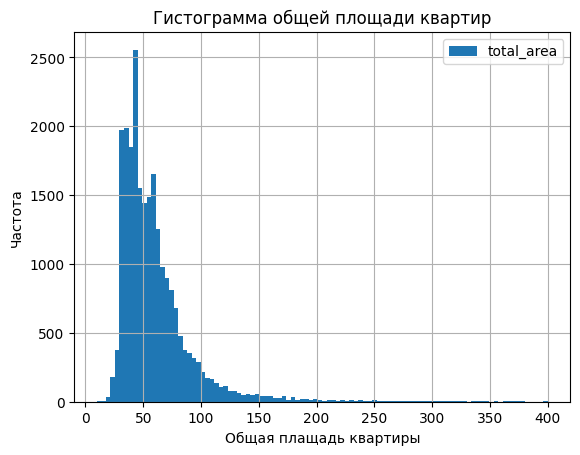

In [84]:
# гистограмма
ax = data.plot(kind='hist', y='total_area', range=(10,400), bins=100, grid=True)
ax.set(title='Гистограмма общей площади квартир', ylabel='Частота', xlabel='Общая плащадь квартиры');

In [85]:
 #основные характеристики выборки
data['total_area'].describe()

count    23383.000000
mean        60.155331
std         34.456164
min         13.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        631.200000
Name: total_area, dtype: float64

In [86]:
#объявления с 5 меньшими значениями
display(data.sort_values(by='total_area').loc[:, ['total_area','rooms', 'living_area', 'kitchen_area', 'locality_name']].head())

,total_area,rooms,living_area,kitchen_area,locality_name
19645,13.0,1,10.000000,2.430634,Санкт-Петербург
19384,13.0,1,7.333762,2.430634,Санкт-Петербург
17809,13.0,1,7.333762,2.430634,Санкт-Петербург
19396,13.2,1,7.446589,2.468028,Санкт-Петербург
19480,14.0,1,11.000000,2.617606,Санкт-Петербург


In [87]:
#объявления с 5 большими значениями
display(data.sort_values(by='total_area').loc[:, ['total_area','rooms', 'living_area', 'kitchen_area', 'locality_name']].tail())

,total_area,rooms,living_area,kitchen_area,locality_name
7954,507.0,5,301.50000,45.5,Санкт-Петербург
4202,517.0,7,332.00000,22.0,Санкт-Петербург
15521,618.0,7,258.00000,70.0,Санкт-Петербург
3091,631.0,7,355.96952,60.0,Санкт-Петербург
12745,631.2,7,322.30000,19.5,Санкт-Петербург


**Выводы:** 

    1) больше всего объявлений о продаже квартир с площадью около 40-70 квадратных метров.
    2) объявлений о продаже квартир с общей площадью 100 кв метров мало.
    3) минимальная общая площадь квартиры - 13 кв метров (однокомнатная квартира в Санкт-Петербурге)
    4) максимальная общая площадь квартиры - 631,2 кв метров (семикомнатная квартира в Санкт-Петербурге)
    5) самые большие и самые маленькие по общей площади квартиры расположены в Санкт-Петербурге

**Анализ данных о жилой площади квартир в предоставленных объявлениях:**

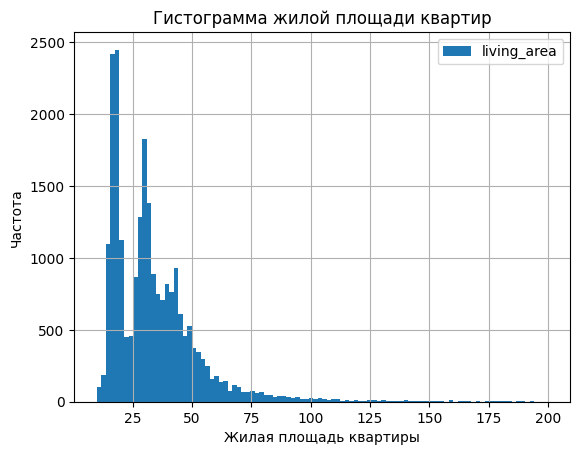

In [88]:
#гистограмма
ax = data.plot(kind='hist', y='living_area', range=(10,200), bins=100, grid=True)
ax.set(title='Гистограмма жилой площади квартир', ylabel='Частота', xlabel='Жилая площадь квартиры');

In [89]:
#характеристики выборки
data['living_area'].describe()

count    23383.000000
mean        34.384186
std         21.623572
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        355.969520
Name: living_area, dtype: float64

In [90]:
#объявления с 5 меньшими значениями
display(data.sort_values(by='living_area').loc[:, ['total_area','rooms', 'living_area', 'kitchen_area', 'locality_name']].head())

,total_area,rooms,living_area,kitchen_area,locality_name
13794,52.0,2,2.0,9.000000,Санкт-Петербург
21575,23.0,0,2.0,4.300352,посёлок Мурино
23378,139.0,3,3.0,16.000000,Санкт-Петербург
3216,41.0,1,3.0,11.000000,Санкт-Петербург
17433,22.0,0,5.0,4.113380,Санкт-Петербург


In [91]:
#объявления с 5 большими значениями
display(data.sort_values(by='living_area').loc[:, ['total_area','rooms', 'living_area', 'kitchen_area', 'locality_name']].tail())

,total_area,rooms,living_area,kitchen_area,locality_name
653,483.9,7,312.50000,26.4,Санкт-Петербург
12745,631.2,7,322.30000,19.5,Санкт-Петербург
4202,517.0,7,332.00000,22.0,Санкт-Петербург
12291,495.0,7,347.50000,25.0,Санкт-Петербург
3091,631.0,7,355.96952,60.0,Санкт-Петербург


**Выводы:**

    1) Гистограмма похожа по форме на гистограмму общей площади
    2) Больше всего объявлений о продаже квартир с жилой площадью 18 - 40 кв м
    3) Объявлений о продаже квартир с жилой площадью более 60 кв м мало
    4) Квартиры с минимальными жилыми площадями в однокомнатных квартирах в Санкт-Петербурге
    5) Квартиры с максимальными жилыми площадями в семикомнатных квартирах в Санкт-Петербурге
    

**Анализ данных о площади кухни квартир в предоставленных объявлениях:**

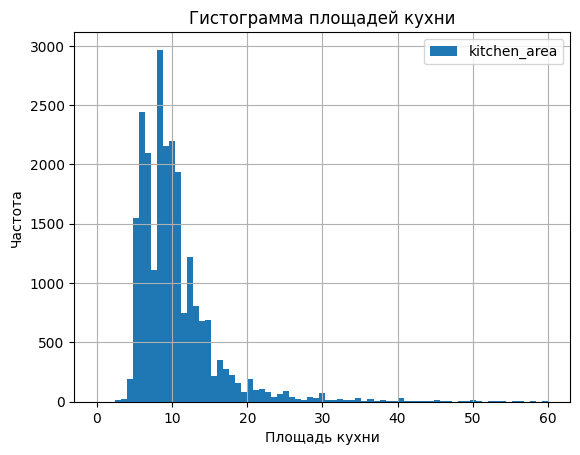

In [92]:
#гистограмма
ax = data.plot(kind='hist', y='kitchen_area', range=(0,60), bins=75, grid=True)
ax.set(title='Гистограмма площадей кухни', ylabel='Частота', xlabel='Площадь кухни');

In [93]:
#характеристики выборки
data['kitchen_area'].describe()

count    23383.000000
mean        10.534520
std          5.957163
min          2.430634
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

In [94]:
 #объявления с 5 меньшими значениями
display(data.sort_values(by='kitchen_area').loc[:, ['total_area','rooms', 'living_area', 'kitchen_area', 'locality_name']].head())

,total_area,rooms,living_area,kitchen_area,locality_name
19645,13.0,1,10.000000,2.430634,Санкт-Петербург
17809,13.0,1,7.333762,2.430634,Санкт-Петербург
19384,13.0,1,7.333762,2.430634,Санкт-Петербург
19396,13.2,1,7.446589,2.468028,Санкт-Петербург
19480,14.0,1,11.000000,2.617606,Санкт-Петербург


In [95]:
#объявления с 5 большими значениями
display(data.sort_values(by='kitchen_area').loc[:, ['total_area','rooms', 'living_area', 'kitchen_area', 'locality_name']].tail())

,total_area,rooms,living_area,kitchen_area,locality_name
16655,146.0,2,40.000000,93.000000,Санкт-Петербург
16106,181.1,3,58.200000,93.200000,Санкт-Петербург
14887,500.0,4,282.067766,93.485918,Санкт-Петербург
2469,255.0,3,153.900000,100.700000,Санкт-Петербург
20048,249.7,3,72.000000,107.000000,Санкт-Петербург


**Выводы:**

    1)Гистограмма похожа по форме на гистограммы общей площади и жилой площади
    2) Больше всего объявлений о продаже квартир с площадью кухни 7-12 кв м
    3) Объявлений о продаже квартир с площадью кухни более 15 кв м мало
    4) Квартиры с минимальными площадями кухни в однокомнатных квартирах в Санкт-Петербурге
    5) Квартиры с максимальными площадями кухни в трехкомнатных квартирах в Санкт-Петербурге

**Анализ данных о стоимости квартир в предоставленных объявлениях:**

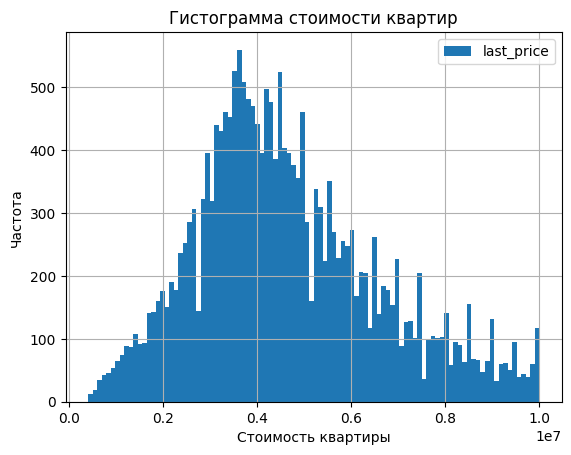

In [96]:
#гистограмма
ax = data.plot(kind='hist', y='last_price', range = (400000, 10000000), bins=100, grid=True)
ax.set(title='Гистограмма стоимости квартир', ylabel='Частота', xlabel='Стоимость квартиры');

In [97]:
#характеристики выборки
data['last_price'].describe()

count    2.338300e+04
mean     6.470720e+06
std      9.286728e+06
min      4.300000e+05
25%      3.422500e+06
50%      4.650000e+06
75%      6.771381e+06
max      4.013000e+08
Name: last_price, dtype: float64

In [98]:
#объявления с 5 меньшим значениями
display(data.sort_values(by='last_price').loc[:, ['last_price', 'total_area','rooms', 'locality_name']].head())

,last_price,total_area,rooms,locality_name
14782,430000.0,54.0,2,посёлок станции Свирь
17310,430000.0,30.4,1,Сланцы
16141,440000.0,40.0,1,деревня Старополье
9509,450000.0,43.4,2,деревня Старополье
5654,450000.0,42.0,2,городской посёлок Будогощь


In [99]:
#объявления с 5 большими значениями
display(data.sort_values(by='last_price').loc[:, ['last_price', 'total_area','rooms', 'locality_name']].tail())

,last_price,total_area,rooms,locality_name
16327,245000000.0,285.7,6,Санкт-Петербург
22638,289238400.0,187.5,2,Санкт-Петербург
15521,300000000.0,618.0,7,Санкт-Петербург
1422,330000000.0,190.0,3,Санкт-Петербург
14578,401300000.0,401.0,5,Санкт-Петербург


**Выводы:**

    1) Больше всего объявлений о продаже квартир стоимостью 3-6 млн рублей
    2) Объявлений о продаже квартир стоимостью меньше 2 млн и больше 8 млн рублей мало
    3) Самые дешевые квартиры расположены в области
    4) Самые дорогие квартиры продаются в Санкт-Петербурге

**Анализ данных о количестве комнат в квартирах в предоставленных объявлениях:**

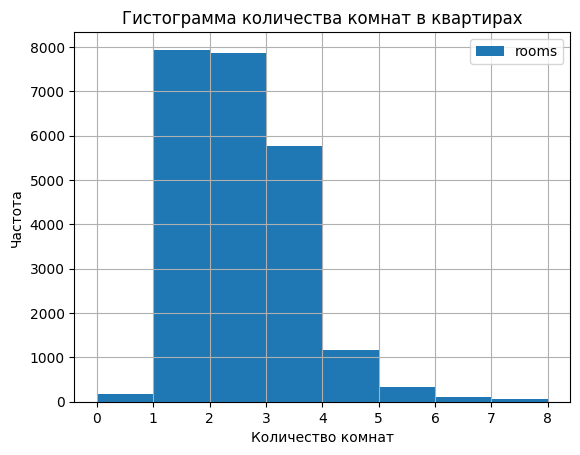

In [100]:
#гистограмма
ax = data.plot(kind='hist', y='rooms', range = (0, 8), bins=8, grid=True)
ax.set(title='Гистограмма количества комнат в квартирах', ylabel='Частота', xlabel='Количество комнат');

In [101]:
#значения и частота встречаемости в объявлениях
data['rooms'].value_counts()

1    7935
2    7854
3    5754
4    1169
5     323
0     176
6     103
7      58
8      11
Name: rooms, dtype: int64

**Выводы:**

    1) Больше всего объявлений о продаже 1 и 2- комнатных квартир
    2) Реже продаются 3-комнатные квартиры
    3) Объявлений о продаже более чем 5-комнатных квартир мало

**Анализ данных о высоте потолков квартир в предоставленных объявлениях:**

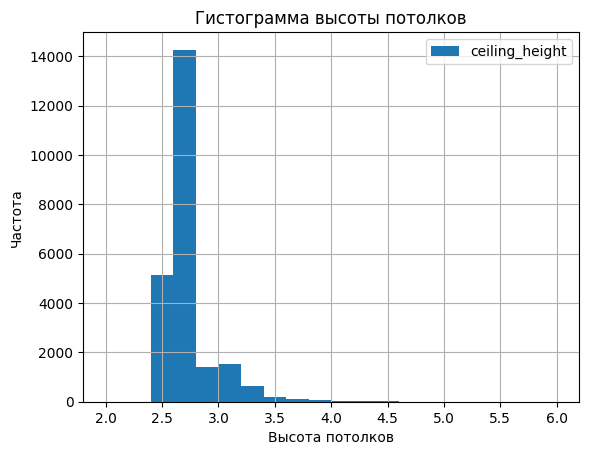

In [102]:
#гистограмма
ax = data.plot(kind='hist', y='ceiling_height', range = (2, 6), bins=20, grid=True)
ax.set(title='Гистограмма высоты потолков', ylabel='Частота', xlabel='Высота потолков');

In [103]:
#основные харктеристики выборки
data['ceiling_height'].describe()

count    23383.000000
mean         2.696593
std          0.219476
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

In [104]:
#объявления с 5 меньшими значениями
display(data.sort_values(by='ceiling_height').loc[:, ['last_price', 'total_area','rooms', 'ceiling_height', 'locality_name']].head())

,last_price,total_area,rooms,ceiling_height,locality_name
12641,1400000.0,22.5,1,2.20,село Копорье
17643,2300000.0,58.6,3,2.25,деревня Бегуницы
20337,5950000.0,60.0,2,2.26,Санкт-Петербург
1568,4100000.0,45.6,2,2.30,Санкт-Петербург
5454,2200000.0,56.0,2,2.30,Сясьстрой


In [105]:
#объявления с 5 большими значениями
display(data.sort_values(by='ceiling_height').loc[:, ['last_price', 'total_area','rooms', 'ceiling_height','locality_name']].tail())

,last_price,total_area,rooms,ceiling_height,locality_name
1017,155000000.0,310.0,5,5.3,Санкт-Петербург
12515,3900000.0,50.0,1,5.3,Санкт-Петербург
7519,38000000.0,143.0,3,5.5,Санкт-Петербург
1375,59800000.0,399.0,5,5.6,Санкт-Петербург
20096,119000000.0,187.6,4,6.0,Санкт-Петербург


**Выводы:**

    1) Больше всего объявлений о продаже квартир с высотой потолка 2,65 м
    2) Квартир с высотой потолка меньше 2,5 м и больше 2,7 м мало
    3) Квартиры с самыми низкими потолками чаще расположены в области
    4) Квартиры с самыми высокими потолками расположены в Санкт-Петербурге

**Анализ данных об этажах, на которых расположены квартиры в предоставленных объявлениях:**

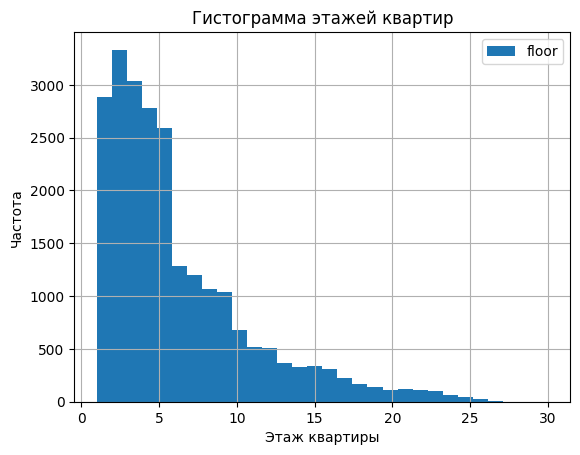

In [106]:
#гистограмма
ax=data.plot(kind='hist', y='floor', range = (1, 30), bins=30, grid=True)
ax.set(title='Гистограмма этажей квартир', ylabel='Частота', xlabel='Этаж квартиры');

In [107]:
#значения и частота встречаемости в объявлениях
display(data['floor'].value_counts())

2     3332
3     3040
1     2883
4     2781
5     2593
6     1284
7     1203
8     1069
9     1041
10     679
11     515
12     512
13     367
15     336
14     329
16     312
17     224
18     171
19     142
21     118
22     110
20     108
23      97
24      60
25      43
26      24
27      10
Name: floor, dtype: int64

**Выводы:**

    1) Чаще всего продают квартиры, рсположенные с 1 по 5 этаж. 
    2) Квартир, расположенных выше 20 этажа мало

**Анализ данных о типе этажа, на котором расположены квартиры в предоставленных объявлениях:**

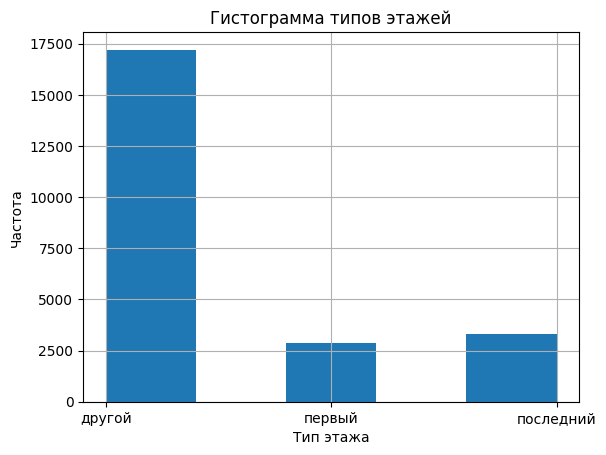

In [108]:
#гистограмма
ax=data['floor_type'].hist(bins=5)
ax.set(title='Гистограмма типов этажей', ylabel='Частота', xlabel='Тип этажа');

**Вывод:**

    1) Чаще всего продают квартиры, расположенные не на первом или последнем этажах

**Анализ данных об этажности домов, в которых расположены квартиры в предоставленных объявлениях:**

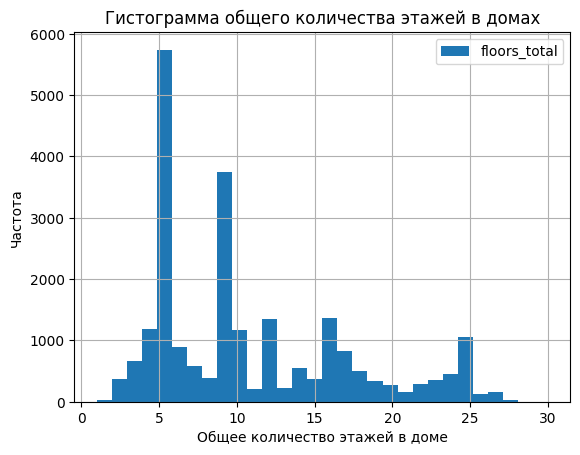

In [109]:
#гистограмма
ax = data.plot(kind='hist', y='floors_total', range = (1, 30), bins=30, grid=True)
ax.set(title='Гистограмма общего количества этажей в домах', ylabel='Частота', xlabel='Общее количество этажей в доме');

In [110]:
#значения и частота встречаемости в объявлениях
display(data['floors_total'].value_counts())

5     5739
9     3748
16    1359
12    1354
4     1184
10    1170
25    1062
6      897
17     826
3      659
7      584
14     550
18     496
24     457
8      387
2      375
15     363
23     348
19     335
22     282
20     271
13     227
11     201
27     163
21     156
26     124
1       25
28      21
35      20
Name: floors_total, dtype: int64

In [111]:
#объявления с 5 меньшими значениями
display(data.sort_values(by='floors_total').loc[:, ['last_price', 'total_area','rooms','floors_total', 'locality_name']].head())

,last_price,total_area,rooms,floors_total,locality_name
21423,1900000.0,40.0,2,1,посёлок Сосново
22360,5800000.0,115.0,2,1,Сестрорецк
23302,1600000.0,54.0,2,1,Высоцк
15413,3500000.0,54.0,2,1,городской поселок Большая Ижора
14707,3900000.0,45.0,2,1,посёлок Стрельна


In [112]:
#объявления с 5 большими значениями
display(data.sort_values(by='floors_total').loc[:, ['last_price', 'total_area', 'floor', 'rooms', 'floors_total','locality_name']].tail()) 

,last_price,total_area,floor,rooms,floors_total,locality_name
15850,5900000.0,62.0,9,2,35,Санкт-Петербург
21626,10600000.0,77.0,11,2,35,Санкт-Петербург
22752,7690000.0,75.0,8,2,35,Санкт-Петербург
18463,7350000.0,68.5,3,2,35,Санкт-Петербург
13853,6990000.0,65.0,23,2,35,Санкт-Петербург


**Выводы:**

    1) Больше всего предоствлено объявлений о продаже квартир, расположенных в 5-этажных домах
    2) Далее по популярности идут квартиры, расположенные в 9-этажных домах
    3) Затем почти на одном уровне 4-, 10-, 12-, 16-, 25- этажные дома
    4) Объявлений о продаже квартиры в одноэтажном доме или выше 28-этажного - единицы
    5) Одноэтажные дома продаются в области
    6) Квартиры в самых многоэтажных домах расположены в Санкт-Петербурге

**Анализ данных о расстоянии до центра города от квартир в предоставленных объявлениях:**

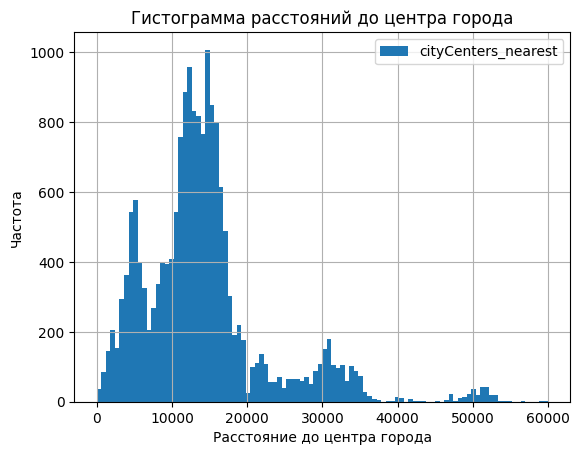

In [113]:
#гистограмма
ax = data.plot(kind='hist', y='cityCenters_nearest', range = (1, 60000), bins=100, grid=True)
ax.set(title='Гистограмма расстояний до центра города', ylabel='Частота', xlabel='Расстояние до центра города');

In [114]:
#основные характеристики выборки
data.loc[data['cityCenters_nearest']!=0, 'cityCenters_nearest'].describe()

count    17931.000000
mean     14203.186102
std       8615.614187
min        181.000000
25%       9241.000000
50%      13101.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

**Выводы:**

    1) Чаще всего продают квартиры на расстояниях от 9 км до 16 км от центра города
    2) Объявлений о продаже квартир, расположенных дальше 20 км от центра города мало
    3) На гистограмме выделяются определенные пики в значениях около 10 км, 12 км и 16 км от центра города

**Анализ данных о расстоянии до ближайшего аэропорта от квартир в предоставленных объявлениях:**

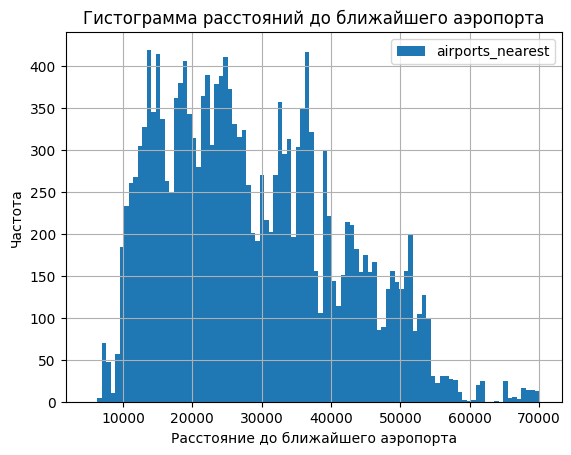

In [115]:
#гистограмма
ax = data.plot(kind='hist', y='airports_nearest', range = (5000, 70000), bins=100, grid=True)
ax.set(title='Гистограмма расстояний до ближайшего аэропорта', ylabel='Частота', xlabel='Расстояние до ближайшего аэропорта');

In [116]:
#основные характеристики выборки
data['airports_nearest'].describe()

count    17908.000000
mean     28817.475039
std      12632.355919
min       6450.000000
25%      18573.750000
50%      26770.000000
75%      37289.500000
max      84869.000000
Name: airports_nearest, dtype: float64

**Вывод:**

1) Большинство продаваемых квартир расположены на расстоянии от 18 км до 40 км от аэропорта (аэропорт Пулково расположен от центра города на растоянии 21 км)

**Анализ данных о расстоянии до ближайшего парка от квартир в предоставленных объявлениях:**

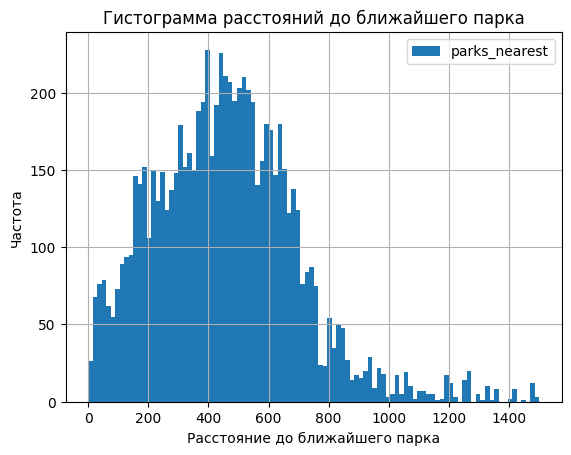

In [117]:
#гистограмма
ax = data.plot(kind='hist', y='parks_nearest', range = (0, 1500), bins=100, grid=True)
ax.set(title='Гистограмма расстояний до ближайшего парка', ylabel='Частота', xlabel='Расстояние до ближайшего парка');

In [118]:
#основные характеристики выборки
data['parks_nearest'].describe()

count    7967.000000
mean      490.917158
std       341.471636
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

**Вывод:**

    1) Большинство квартир расположены на расстоянии от 250 м до 600 м до ближайшего парка

**Анализ данных о дне недели публикации объявлений о продаже квартир:**

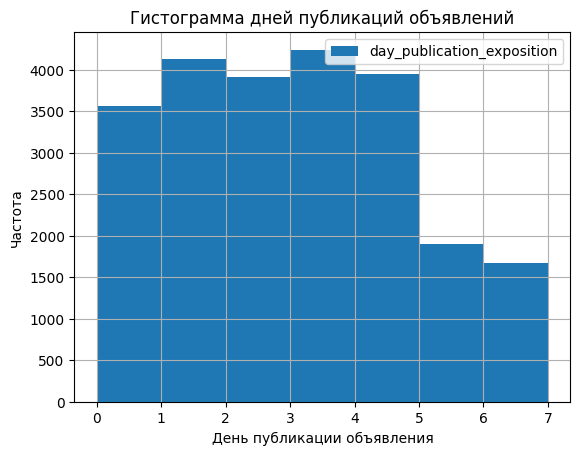

In [119]:
#гистограмма
ax = data.plot(kind='hist', y='day_publication_exposition', range = (0, 7), bins=7, grid=True)
ax.set(title='Гистограмма дней публикаций объявлений', ylabel='Частота', xlabel='День публикации объявления');

In [120]:
#значения и частота встречаемости
display(data['day_publication_exposition'].value_counts())

3    4244
1    4128
4    3956
2    3916
0    3565
5    1905
6    1669
Name: day_publication_exposition, dtype: int64

**Выводы:**

    1) Большинсто объявлений о продаже квартиры были выставлены во вторник и четверг
    2) Меньше всего объявлений выставлены в субботу и воскресенье

**Анализ данных о месяце публикации объявления о продаже квартиры:**

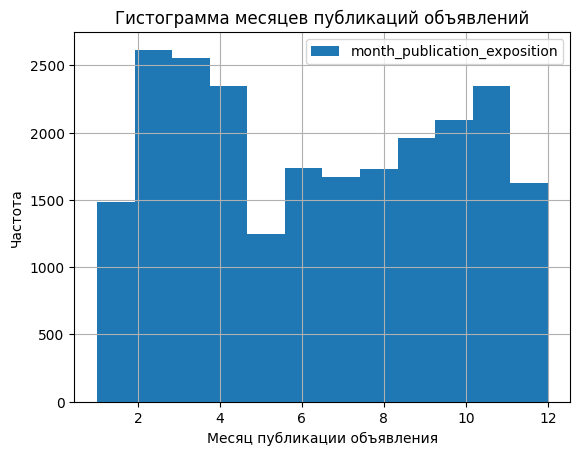

In [121]:
#гистограмма
ax = data.plot(kind='hist', y='month_publication_exposition', range = (1, 12), bins=12, grid=True)
ax.set(title='Гистограмма месяцев публикаций объявлений', ylabel='Частота', xlabel='Месяц публикации объявления');

In [122]:
#значения и частота встречаемости
display(data['month_publication_exposition'].value_counts())

2     2616
3     2553
11    2345
4     2342
10    2090
9     1958
6     1734
8     1731
7     1666
12    1622
1     1480
5     1246
Name: month_publication_exposition, dtype: int64

**Выводы:**

    1) Чаще всего размещают объявления о продаже квартир в феврале, марте, апреле и ноябре
    2) Реже всего размещают объявления о продаже квартир в январе и мае

### 3.1 Анализ данных о количестве дней, сколько были размещены объявления о продаже квартиры:
<a id='intro_8'> </a>

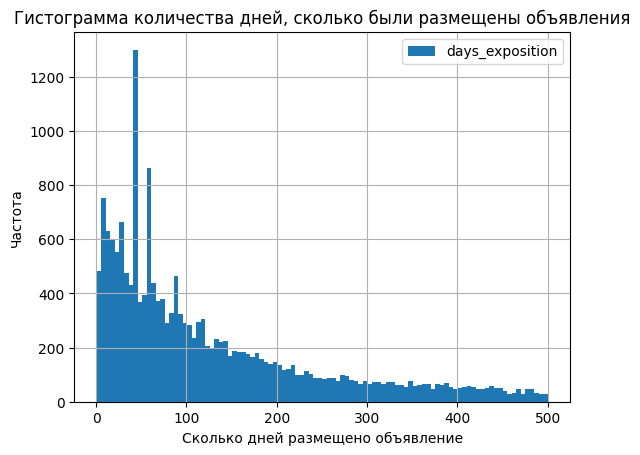

In [123]:
#гистограмма
ax = data[data['days_exposition'] !=0].plot(kind='hist', y='days_exposition', range = (1, 500), bins=100, grid=True)
ax.set(title='Гистограмма количества дней, сколько были размещены объявления', ylabel='Частота', xlabel='Сколько дней размещено объявление');

In [124]:
#основные характеристики выборки (без учет значения 0 - маркера для данных, где были пропущены значения)
data.loc[data['days_exposition']!=0, 'days_exposition'].describe()

count    23383.000000
mean       156.460505
std        213.727897
min         -1.000000
25%         22.000000
50%         73.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [125]:
print('Среднее значение = ', data.loc[data['days_exposition']!=0, 'days_exposition'].mean())
print('Медиана =', data.loc[data['days_exposition']!=0, 'days_exposition'].median())

Среднее значение =  156.4605054954454
Медиана = 73.0


In [126]:
#значения и частота встречаемости
data.loc[data['days_exposition']!=0, 'days_exposition'].value_counts()

-1       3145
 45       872
 60       533
 7        227
 30       207
         ... 
 1112       1
 1080       1
 1064       1
 1032       1
 1391       1
Name: days_exposition, Length: 1139, dtype: int64

**Выводы:**

    1) Чаще всего объявления о продаже квартиры размещаются на 45 дней
    2) Продажи быстрее 45 дней можно считать быстрыми
    3) Продажи дольше 230 дней можно считать долгими

### 3.2. Определение фактовов, больше всего влияющих на общую (полную) стоимость объекта
<a id='intro_4'> </a>

Анализ зависимости общей (полной) стоимости объекта от общей площади:

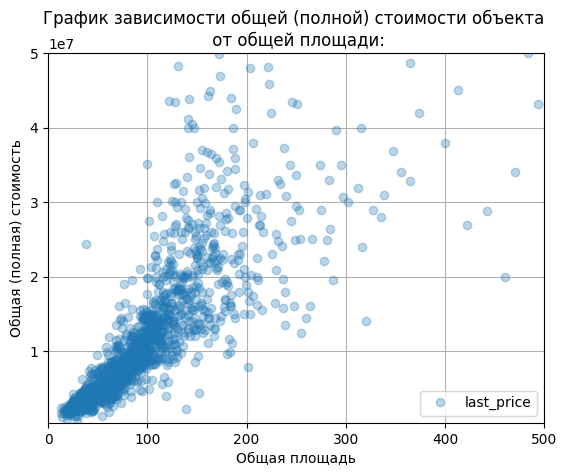

In [127]:
ax = (data
          .pivot_table(index='total_area', values='last_price')
          .plot(grid=True, style='o', xlim=(0, 500), ylim=(400000, 50000000), sharex=False, alpha=0.3)
     )
ax.set(title='График зависимости общей (полной) стоимости объекта \n от общей площади:', xlabel='Общая площадь',\
       ylabel='Общая (полная) стоимость');

In [128]:
#посчитаем коэффициент корреляции Пирсона для указанных величин
data['total_area'].corr(data['last_price'])

0.6959497019647252

Анализ зависимости общей (полной) стоимости объекта от жилой площади:

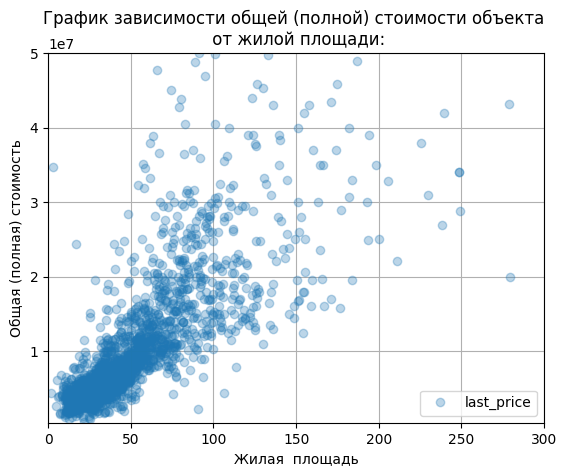

In [129]:
ax = (data
          .pivot_table(index='living_area', values='last_price')
          .plot(grid=True, style='o', xlim=(0, 300), ylim=(400000, 50000000), sharex=False, alpha=0.3)
      );
ax.set(title='График зависимости общей (полной) стоимости объекта \n от жилой площади:', xlabel='Жилая  площадь',\
        ylabel='Общая (полная) стоимость');

In [130]:
#посчитаем коэффициент корреляции Пирсона для указанных величин
data['living_area'].corr(data['last_price'])

0.6211317117085196

Анализ зависимости общей (полной) стоимости объекта от площади кухни:

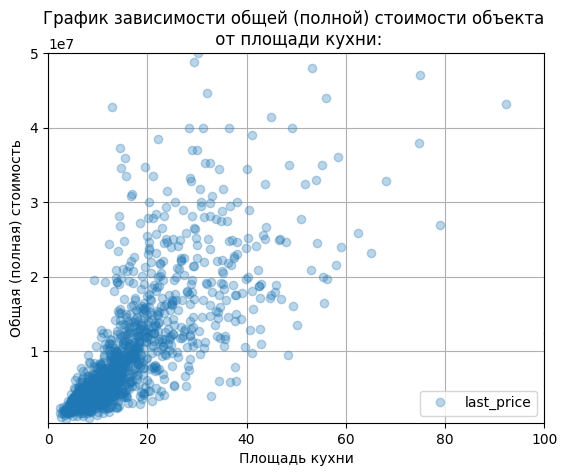

In [131]:
ax = (data
          .pivot_table(index='kitchen_area', values='last_price')
          .plot(grid=True, style='o', xlim=(0, 100), ylim=(400000, 50000000), sharex=False, alpha=0.3)
      )
ax.set(title='График зависимости общей (полной) стоимости объекта \n от площади кухни:', xlabel='Площадь кухни',\
      ylabel='Общая (полная) стоимость');

In [132]:
 #посчитаем коэффициент корреляции Пирсона для указанных величин
data['kitchen_area'].corr(data['last_price'])

0.5382131165286531

Анализ зависимости общей (полной) стоимости объекта от количества комнат:

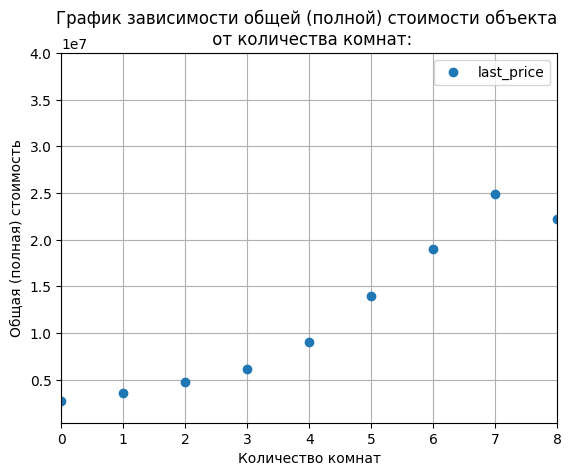

In [133]:
ax = (data
          .pivot_table(index='rooms', values='last_price', aggfunc='median')
          .plot(grid=True, style='o', xlim=(0, 8), ylim=(400000, 40000000), sharex=False, alpha=1)
      );
ax.set(title='График зависимости общей (полной) стоимости объекта \n от количества комнат:', xlabel='Количество комнат',\
      ylabel='Общая (полная) стоимость');

In [134]:
#посчитаем коэффициент корреляции Пирсона для указанных величин
data['rooms'].corr(data['last_price'])

0.3855508146125207

Анализ зависимости общей (полной) стоимости объекта от типа этажа квартиры:

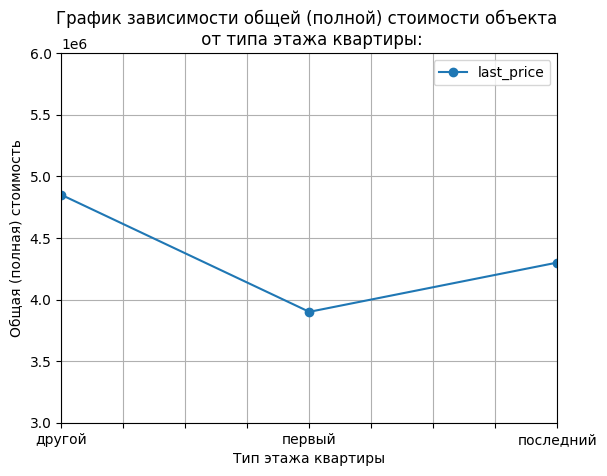

In [135]:
ax = (data
          .pivot_table(index='floor_type', values='last_price', aggfunc='median')
          .plot(grid=True, style='o-', xlim=(0, 2), ylim=(3000000, 6000000), sharex=False, alpha=1)
     )
ax.set(title='График зависимости общей (полной) стоимости объекта \n от типа этажа квартиры:', xlabel='Тип этажа квартиры',\
      ylabel='Общая (полная) стоимость');

Анализ зависимости общей (полной) стоимости объекта от дня недели публикации объявления:

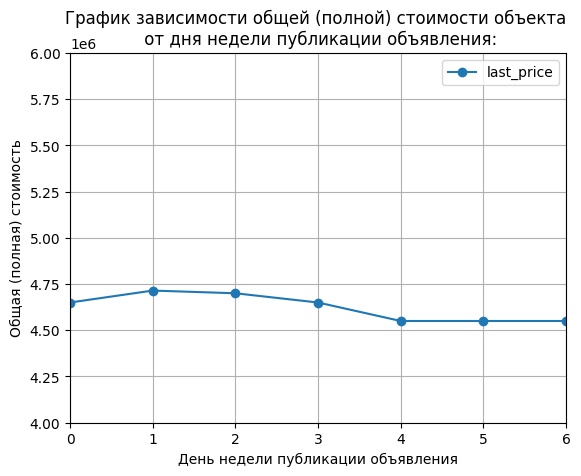

In [136]:
ax = (data
          .pivot_table(index='day_publication_exposition', values='last_price', aggfunc='median')
          .plot(grid=True, style='o-', xlim=(0, 6), ylim=(4000000, 6000000), sharex=False, alpha=1)
      )
ax.set(title='График зависимости общей (полной) стоимости объекта \n от дня недели публикации объявления:',\
       xlabel='День недели публикации объявления', ylabel='Общая (полная) стоимость');

Анализ зависимости общей (полной) стоимости объекта от месяца публикации объявления:

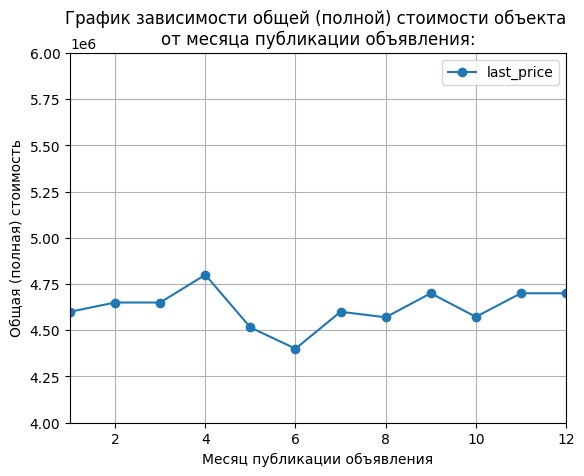

In [137]:
ax = (data
          .pivot_table(index='month_publication_exposition', values='last_price', aggfunc='median')
          .plot(grid=True, style='o-', xlim=(1, 12), ylim=(4000000, 6000000), sharex=False, alpha=1)
      )
ax.set(title = 'График зависимости общей (полной) стоимости объекта \nот месяца публикации объявления:',\
       xlabel='Месяц публикации объявления', ylabel='Общая (полная) стоимость');

Анализ зависимости общей (полной) стоимости объекта от года публикации объявления:

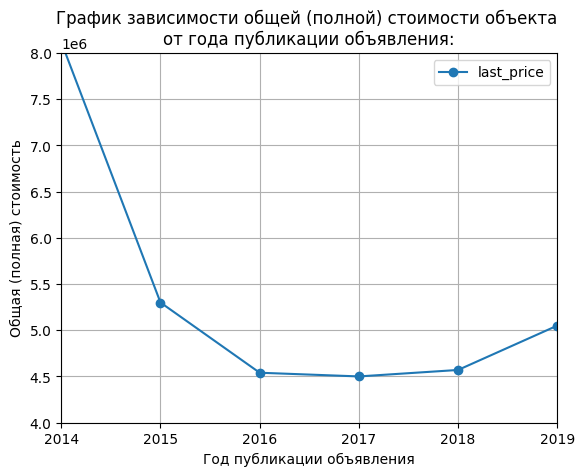

In [138]:
ax = (data
          .pivot_table(index='year_publication_exposition', values='last_price', aggfunc='median')
          .plot(grid=True, style='o-', xlim=(2014, 2019), ylim=(4000000, 8000000), sharex=False, alpha=1)
      )
ax.set(title='График зависимости общей (полной) стоимости объекта \nот года публикации объявления:',\
      xlabel='Год публикации объявления', ylabel='Общая (полная) стоимость');

**Выводы:**
1) В результате анализа установлена зависимость общей (полной) стоимости объекта от общей площади: 
для квартир общей площадью меньше 100 кв м (а из анализа данных определено, что это большинство квартир) видна положительная, близкая к линейной, зависимость: чем больше общая площадь квартиры, тем выше цена. Данную гиптезу также подтверждает коэффициент корреляции Пирсона (равный 0,695)

2) В результате анализа установлена зависимость общей (полной) стоимости объекта от жилой площади: 
для квартир с жилой площадью меньше 50 кв м (а из анализа данных определено, что это большинство квартир) видна положительная, близкая к линейной, зависимость: чем больше жилая площадь квартиры, тем выше цена. Данную гиптезу также подтверждает коэффициент корреляции Пирсона (равный 0,624)

3)В результате анализа установлена зависимость общей (полной) стоимости объекта от площади кухни: 
для квартир с площадью кухни меньше 20 кв м (а из анализа данных определено, что это большинство квартир) видна положительная зависимость: чем больше площадь кухни квартиры, тем выше цена. Однако здесь график достаточно "широкий", поэтому говорить о линейной зависимости достаточно сложно. Данню гиптезу также подтверждает коэффициент корреляции Пирсона (равный 0,54).

4) Графики зависимости цены от общей, жилой площадей и площади кухни имеют похожий вид.

5)В результате анализа установлена зависимость общей (полной) стоимости объекта от количества комнат: 
для квартир с количеством комнат меньше или равным 7 (а из анализа данных определено, что это большинство квартир) видна положительная зависимость: чем больше комнат в квартире, тем выше цена.Однако зависимость больше похожа на параболу, чем на линейную. Коэффициент корреляции Пирсона равен 0,39.

6) В результате анализа установлена следующая зависимость общей (полной) стоимости объекта от типа этажа, на котором расположена квартира: дороже квартиры, расположенные не на первом или последнем этаже, самыми дешевыми квартирами являются те, которые расположены на первом этаже.

7) В результате анализа установлена следующая зависимость общей (полной) стоимости объекта от дня недели публикации объявления: самыми дорогими оказались квартиры, чьи объявления публиковались во вторник и среду, дешевыми - в пятницу, субботу и воскресенье. В целом прослеживается увелечение цены к середине недели и ее уменьшее к концу недели.

8) В результате анализа установлена следующая зависимость общей (полной) стоимости объекта от месяца публикации объявления: самыми дорогими оказались квартиры, чьи объявления публиковались в апреле, самыми дешевыми - в июне. В целом прослеживается синусная зависимость цены от месяца: цена периодически возрастает - падает.

9) В результате анализа установлена следующая зависимость общей (полной) стоимости объекта от года публикации объявления: с 2014 по 2016 года прослеживатся падение цен, в 2016-2017 годах цена не изменилась, с 2017 года цена начала расти.

### 3.3. Определение средней цены одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений
<a id='intro_5'> </a>

In [139]:
#определяем перечень 10 населенных пунктов с наибольшим числом объявлений
locality_name_major=data['locality_name_new'].value_counts()[:10].index

In [140]:
#выведем на экран таблицу со значениями средней цены одного квадратного метра в населенных пунктах из locality_name_major
data.query('locality_name_new in @locality_name_major').pivot_table(index='locality_name_new', \
                                                                    values='price_per_square').sort_values(by='price_per_square')

,price_per_square
locality_name_new,
Выборг,58251.091046
Гатчина,68625.141404
Всеволожск,68667.473985
Колпино,75480.547446
поселок Шушары,78546.979088
Мурино,85885.774301
поселок Парголово,90120.391488
Кудрово,95267.605087
Пушкин,103125.819291


**Вывод:**
1) Населенный пункт с самой высокой стоимостью квадратного метра - Санкт Петербург.

2) Населенный пункт с самой низкой стоимостью квадратного метра - Выборг (он также является самым далеким населеным пунктом от Санкт-Петербурга).

### 3.4. Определение средней цены каждого километра до центра города для квартир, расположенных в Санкт-Петербурге
<a id='intro_6'> </a>

Для корректного преобразования данных о расстоянии до центра города в км в целочисленный вид мы заменили отсутствующие значения на 0. Поэтому для корректного расчета средней цены за км данные строки необходимо пропустить.

In [141]:
#определим строки без нулевых значений в стоблце cityCenters_nearest_km
data_new = data[data['cityCenters_nearest_km'] != 0]

In [142]:
#определяем среднюю
print('Средняя цена каждого км до центра города для квартир, расположеных в Санкт-Петербурге:', \
      (data_new.query('locality_name_new == "Санкт-Петербург"')['last_price']/data_new.query('locality_name_new == "Санкт-Петербург"')\
       ['cityCenters_nearest_km']).mean().astype('int'))

Средняя цена каждого км до центра города для квартир, расположеных в Санкт-Петербурге: 1414561


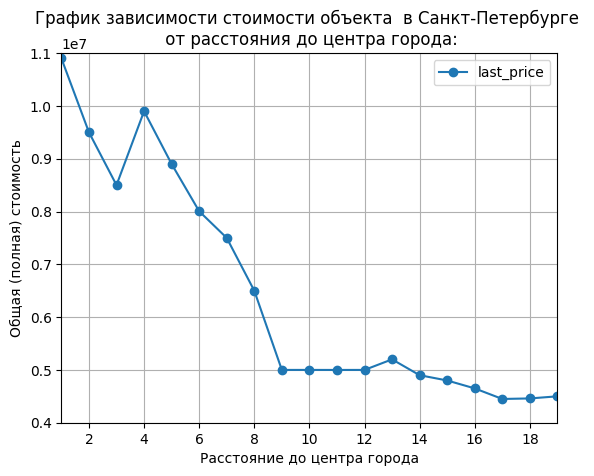

In [143]:
ax = (data
          .query('locality_name_new == "Санкт-Петербург"')
          .pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median')
          .plot(grid=True, style='o-', xlim=(1, 19), ylim=(4000000, 11000000), sharex=False, alpha=1)
      )
ax.set(title='График зависимости стоимости объекта  в Санкт-Петербурге \n от расстояния до центра города:',\
      xlabel='Расстояние до центра города', ylabel='Общая (полная) стоимость');

**Вывод:** С увеличением расстояния от центра города цена понижается. Пик на 3 км возможен ввиду малого количества объявлений (большинство объявлений даны в диапазоне от 9 до 19 км)

### 4. Выводы
<a id='intro_7'> </a>

    1) Ознакомились с предоставленными данными сервиса.
    2) В результате предобработки данных:
        - пропущенные значения заполнены там, где это возможно,
        - некорректные типы данных изменены,
        - неявные дубликаты устранены,
        - аномальные значения устранены.
    3) В таблицу исходных данных рассчитаны значения, необходимые для проведения дальнейшего анализа, и добавлены в соответсвующие столбцы
    4) В результате проведения исследовательского анализа данных установлено:
        - больше всего объявлений о продаже квартир с общей площадью около 40-70 кв метров;
        - объявлений о продаже квартир с общей площадью 100 кв метров мало;
        - больше всего объявлений о продаже квартир с жилой площадью 18 - 40 кв метров;
        - объявлений о продаже квартир с жилой площадью более 60 кв м мало;
        - больше всего объявлений о продаже квартир с площадью кухни 7-12 кв метров;
        - объявлений о продаже квартир с площадью кухни более 15 кв м мало;
        - гистограммы данных об общей, жилой площадях и площади кухни очень похожи;
        - больше всего объявлений о продаже квартир стоимостью 3-6 млн рублей;
        - объявлений о продаже квартир стоимостью меньше 2 млн и больше 8 млн рублей мало;
        - больше всего объявлений о продаже 1 и 2- комнатных квартир;
        - объявлений о продаже более чем 5-комнатных квартир мало;
        - больше всего объявлений о продаже квартир с высотой потолка 2,65 м;
        - квартир с высотой потолка меньше 2,5 м и больше 2,7 м мало;
        - чаще всего продают квартиры, расположенные с 1 по 5 этаж;
        - чаще всего продают квартиры, расположенные не на первом или последнем этажах;
        - больше всего предоствлено объявлений о продаже квартир, расположенных в 5-этажных домах, далее по популярности идут квартиры, расположенные в 9-этажных домах, затем почти на одном уровне 4-, 10-, 12-, 16-, 25- этажные дома;
        - объявлений о продаже квартиры в одноэтажном доме или выше 28-этажного - единицы;
        - чаще всего продают квартиры на расстояниях от 9 км до 16 км от центра города;
        - большинство продаваемых квартир расположены на расстоянии от 18 км до 40 км от аэропорта (аэропорт Пулково расположен от центра города на растоянии 21 км);
        - большинство квартир расположены на расстоянии от 250 м до 600 м до ближайшего парка;
        - большинсто объявлений о продаже квартиры были выставлены во вторник и четверг;
        - меньше всего объявлений выставлены в субботу и воскресенье;
        - чаще всего размещают объявления о продаже квартир в феврале, марте, апреле и ноябре;
        - реже всего размещают объявления о продаже квартир в январе и мае;
        - чаще всего объявления о продаже квартиры размещаются на 45 дней;
        - продажи быстрее 45 дней можно считать быстрыми;
        - продажи дольше 230 дней можно считать долгими.
    5) В результате анализа наличия зависимости общей (полной) стоимости объекта от:
        - общей площади: для квартир общей площадью меньше 100 кв м (а из анализа данных определено, что это большинство квартир) видна положительная, близкая к линейной, зависимость: чем больше общая площадь квартиры, тем выше цена. Данную гиптезу также подтверждает коэффициент корреляции Пирсона (равный 0,695);
        - жилой площади: для квартир с жилой площадью меньше 50 кв м (а из анализа данных определено, что это большинство квартир) видна положительная, близкая к линейной, зависимость: чем больше жилая площадь квартиры, тем выше цена. Данную гиптезу также подтверждает коэффициент корреляции Пирсона (равный 0,624);
        - площади кухни: для квартир с площадью кухни меньше 20 кв м (а из анализа данных определено, что это большинство квартир) видна положительная зависимость: чем больше площадь кухни квартиры, тем выше цена. Однако здесь график достаточно "широкий", поэтому говорить о линейной зависимости достаточно сложно. Данню гиптезу также подтверждает коэффициент корреляции Пирсона (равный 0,54);
        - количества комнат: для квартир с количеством комнат меньше или равным 7 (а из анализа данных определено, что это большинство квартир) видна положительная зависимость: чем больше комнат в квартире, тем выше цена.Однако зависимость больше похожа на параболу, чем на линейную. Коэффициент корреляции Пирсона равен 0,39;
        - типа этажа, на котором расположена квартира: дороже квартиры, расположенные не на первом или последнем этаже, самыми дешевыми квартирами являются те, которые расположены на первом этаже;
        - дня недели публикации объявления: самыми дорогими оказались квартиры, чьи объявления публиковались во вторник и среду, дешевыми - в пятницу, субботу и воскресенье. В целом прослеживается увелечение цены к середине недели и ее уменьшее к концу недели;
        - месяца публикации объявления: самыми дорогими оказались квартиры, чьи объявления публиковались в апреле, самыми дешевыми - в июне. В целом прослеживается синусная зависимость цены от месяца: цена периодически возрастает - падает;
        - года публикации объявления: с 2014 по 2016 года прослеживатся падение цен, в 2016-2017 годах цена не изменилась, с 2017 года цена начала расти.
    6) Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Установлено, что населенный пункт с самой высокой стоимостью квадратного метра - Санкт Петербург, с самой низкой стоимостью квадратного метра - Выборг (он также является самым далеким населеным пунктом от Санкт-Петербурга). 
    7) Средняя цена каждого км до центра города для квартир, расположеных в Санкт-Петербурге: 1427767 руб. С увеличением расстояния от центра города цена понижается.